<h1 style="font-size:3rem;color:maroon;"> Predicting Air Pollution Level using Machine Learning</h1>

This notebook looks into using various Python-based machine learning and data science libraries in an attempt to build a machine learning model capable of predicting air pollution level in an area in Eindhoven in the upcoming week.

We"re going to take the following approach:
1. Problem definition
2. Data
3. Features
4. Data Exploration & Visualization
5. Data Preparation
6. Modelling

<h2><font color=slateblue> 1. Problem Definition </font></h2>

In a statement,
> Given historical pollution data, weather data and people going through an area, can we predict air pollution level (fine particle matter level pm2.5) in an area in Eindhoven in the upcoming week?

<h2><font color=slateblue> 2. Data </font></h2>

The data is provided by TNO and Zicht op Data.

<h2><font color=slateblue> 3. Features </font></h2>

This is where you"ll get different information about each of the features in our data.

We have three separate datasets for the period between 25-09-2021 and 30-12-2021:

**Air pollution**
* date: date in ymd_hms
* PC4: postcode
* pm2.5: particulate matter <2.5um in ug/m3
* pm10: particulate matter <10um in ug/m3
* no2: nitrogen dioxide in ug/m3
* no: nitrogen oxide in ug/m3
* so2: sulphur dioxide in ug/m3


**Meteo**
* date: date in ymd_hms
* PC4: postcode
* wd: wind direction in degrees 0-360
* ws: wind speed in m/s
* blh: boundary layer height in metres
* tcc: total cloud cover in oktas (0-9)
* ssrd: solar surface radiation downwards in W/m2 

(see https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview for more information)

**Zichtop**
* PC4: postcode
* date: date in ymd_hms
* pop_tot: total number of people in PC4 for each time step
* m00_30: number of people who have been there for up to 30 minutes
* m30_60: number of people who have been there for 30 and 60 minutes
* H1_2: number of people who have been there for 1 and 2 hours
* H2_4: number of people who have been there for 2 and 4 hours
* H4_8: number of people who have been there for 4 and 8 hours
* H8_16: number of people who have been there for 8 and 16 hours
* H16plus: number of people who have been there for over 16 hours

<h2><font color=slateblue> Preparing the tools </font></h2>

In [247]:
# Regular EDA (exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pgeocode
import plotly.express as px

# Set the style
plt.style.use("ggplot")
# plt.style.available

<h2><font color=slateblue> 4. Data Exploration & Visualization </font></h2>

<h3><font color=steelblue>Zicht op Data dataset </font></h3>

<h4><font color=mediumvioletred>Read CSV files </font></h4>

In [248]:
# read zichtop dataset csv file
df_zichtop = pd.read_csv("data/zichtop.csv", 
                    parse_dates=["date"])

# read air_pollution dataset csv file
df_air_pollution = pd.read_csv("data/air_pollution.csv",
                    parse_dates=["date"])

<h4><font color=mediumvioletred>Get a sample </font></h4>

In [249]:
# zichtop sample
df_zichtop.head(10)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
0,5611,2021-01-01 00:00:00,830,136.0,80.0,34.0,57.0,34.0,34.0,455.0
1,5611,2021-01-01 01:00:00,837,138.0,11.0,23.0,92.0,23.0,80.0,470.0
2,5611,2021-01-01 02:00:00,745,41.0,0.0,0.0,82.0,51.0,71.0,500.0
3,5611,2021-01-01 03:00:00,876,115.0,0.0,0.0,52.0,21.0,125.0,563.0
4,5611,2021-01-01 04:00:00,714,49.0,0.0,0.0,37.0,25.0,111.0,492.0
5,5611,2021-01-01 05:00:00,702,28.0,0.0,0.0,0.0,28.0,183.0,463.0
6,5611,2021-01-01 06:00:00,888,53.0,0.0,0.0,18.0,89.0,160.0,568.0
7,5611,2021-01-01 07:00:00,1182,148.0,0.0,0.0,0.0,84.0,169.0,781.0
8,5611,2021-01-01 08:00:00,1263,134.0,38.0,0.0,19.0,115.0,268.0,689.0
9,5611,2021-01-01 09:00:00,1514,214.0,71.0,0.0,71.0,160.0,303.0,695.0


In [250]:
# air_pollution sample
df_air_pollution.sample(5)

,date,PC4,pm10,pm2.5,no2,no,so2
23700,2021-11-13 12:00:00,5628,14.077185,11.448469,22.232430,14.545686,1.960838
51910,2021-10-13 22:00:00,5658,13.669380,8.384414,43.171127,28.244940,7.054333
4990,2021-10-01 22:00:00,5614,5.698353,3.057590,10.175015,6.657058,1.365440
8749,2021-10-24 13:00:00,5616,8.000954,3.866685,9.073899,5.936647,4.012462
53020,2021-11-29 04:00:00,5658,7.551492,5.430767,16.280518,10.651616,3.186122


<h4><font color=mediumvioletred>Get number of rows and columns </font></h4>

In [251]:
df_zichtop.shape

(255024, 10)

<h4><font color=mediumvioletred>Get types of columns </font></h4>

In [252]:
df_zichtop.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
dtype: object

<h4><font color=mediumvioletred>Get some info about each column (type, number of null values..) </font></h4>

In [253]:
df_zichtop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255024 entries, 0 to 255023
Data columns (total 10 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   PC4      255024 non-null  int64         
 1   date     255024 non-null  datetime64[ns]
 2   pop_tot  255024 non-null  int64         
 3   m00_30   254276 non-null  float64       
 4   m30_60   254276 non-null  float64       
 5   H1_2     254276 non-null  float64       
 6   H2_4     254276 non-null  float64       
 7   H4_8     254276 non-null  float64       
 8   H8_16    254276 non-null  float64       
 9   H16plus  254276 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 19.5 MB


<h4><font color=mediumvioletred>Get some info about numerical columns (count, mean, min...) </font></h4>

In [254]:
df_zichtop.describe()

,PC4,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
count,255024.000000,255024.000000,254276.000000,254276.000000,254276.00000,254276.000000,254276.000000,254276.000000,254276.000000
mean,5633.818182,1984.896131,334.580322,41.012966,73.50676,126.323121,237.291384,349.584455,827.626296
std,15.168687,1285.972747,376.307733,61.055502,104.01577,186.176472,331.758108,380.206726,538.795020
min,5611.000000,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-3.000000
25%,5622.000000,1060.000000,56.000000,0.000000,0.00000,9.000000,38.000000,98.000000,471.000000
50%,5631.000000,1703.000000,222.000000,15.000000,32.00000,62.000000,119.000000,236.000000,781.000000
75%,5646.000000,2615.000000,481.000000,60.000000,107.00000,173.000000,292.000000,454.000000,1093.000000
max,5658.000000,11617.000000,4885.000000,2090.000000,1564.00000,5326.000000,3515.000000,3368.000000,3409.000000


<h4><font color=mediumvioletred>Merge zichtop and air_pollution datasets </font></h4>

In [255]:
df_zichtop_air_pollution = pd.merge(df_zichtop, df_air_pollution[["PC4","date", "pm2.5"]], on=["PC4", "date"])
df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,pm2.5
28164,5643,2021-10-13 12:00:00,3282,541.0,54.0,108.0,325.0,974.0,830.0,450.0,3.846392
1709,5612,2021-10-11 05:00:00,4626,925.0,17.0,51.0,103.0,497.0,1525.0,1508.0,10.015119
26067,5641,2021-11-05 03:00:00,1041,0.0,0.0,0.0,41.0,33.0,82.0,885.0,6.146854
2901,5613,2021-10-05 21:00:00,1752,161.0,0.0,0.0,36.0,36.0,304.0,1215.0,3.440323
11667,5622,2021-11-10 03:00:00,1060,0.0,0.0,0.0,9.0,0.0,74.0,977.0,20.857685


In [256]:
df_zichtop_air_pollution.dtypes

PC4                 int64
date       datetime64[ns]
pop_tot             int64
m00_30            float64
m30_60            float64
H1_2              float64
H2_4              float64
H4_8              float64
H8_16             float64
H16plus           float64
pm2.5             float64
dtype: object

<h4><font color=mediumvioletred>Reorder columns in zichtop air pollution dataset </font></h4>

In [257]:
zichtop_air_pollution_features = [
    "PC4",
    "date",
    "pop_tot",
    "pm2.5",
    "m00_30",
    "m30_60",
    "H1_2",
    "H2_4",
    "H4_8",
    "H8_16",
    "H16plus"
]

df_zichtop_air_pollution = df_zichtop_air_pollution.reindex(zichtop_air_pollution_features, axis=1)

df_zichtop_air_pollution.sample(5)

,PC4,date,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
706,5611,2021-10-24 10:00:00,6811,6.128358,951.0,291.0,675.0,1534.0,1181.0,1135.0,1044.0
40,5611,2021-09-26 16:00:00,5062,4.109934,676.0,94.0,503.0,818.0,1226.0,550.0,1195.0
7822,5616,2021-11-14 22:00:00,1439,13.419935,72.0,0.0,36.0,58.0,94.0,260.0,919.0
30897,5645,2021-10-17 09:00:00,1289,11.539431,140.0,26.0,77.0,38.0,179.0,294.0,535.0
1892,5612,2021-10-18 20:00:00,3450,10.454750,572.0,39.0,177.0,197.0,256.0,572.0,1637.0


<h4><font color=mediumvioletred>Rename the date column to date_time </font></h4>

In [258]:
df_zichtop_air_pollution.rename(columns={"date": "date_time"}, inplace=True)

<h4><font color=mediumvioletred>Separate date_time column to date and time </font></h4>

In [259]:
df_zichtop_air_pollution["date"] = df_zichtop_air_pollution["date_time"].dt.date.astype(str)
df_zichtop_air_pollution["time"] = df_zichtop_air_pollution["date_time"].dt.time.astype(str)

In [260]:
df_zichtop_air_pollution.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
20074,5629,2021-10-06 10:00:00,3453,3.267068,752.0,86.0,210.0,506.0,407.0,259.0,1233.0,2021-10-06,10:00:00
15668,5625,2021-11-11 20:00:00,2138,32.798222,212.0,20.0,40.0,171.0,182.0,343.0,1170.0,2021-11-11,20:00:00
33798,5651,2021-10-28 06:00:00,6904,14.443993,1789.0,145.0,235.0,506.0,831.0,2838.0,560.0,2021-10-28,06:00:00
38586,5655,2021-10-07 18:00:00,1805,10.642241,228.0,0.0,16.0,49.0,81.0,163.0,1268.0,2021-10-07,18:00:00
21253,5631,2021-09-30 13:00:00,5199,3.890155,795.0,98.0,195.0,530.0,2021.0,1032.0,528.0,2021-09-30,13:00:00


<h4><font color=mediumvioletred>Correlation between numerical columns </font></h4>

In [261]:
df_zichtop_air_pollution.corr()

,PC4,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus
PC4,1.000000,-0.085402,-0.040311,0.050393,-0.068758,-0.123084,-0.137336,-0.118519,-0.033977,-0.052989
pop_tot,-0.085402,1.000000,-0.016892,0.750560,0.708953,0.749542,0.761389,0.815847,0.842051,0.199654
pm2.5,-0.040311,-0.016892,1.000000,-0.094783,-0.025442,-0.015412,-0.017758,0.005160,0.018352,0.025760
m00_30,0.050393,0.750560,-0.094783,1.000000,0.640048,0.621415,0.589695,0.550787,0.616381,-0.189647
m30_60,-0.068758,0.708953,-0.025442,0.640048,1.000000,0.749745,0.676787,0.609642,0.572131,-0.137459
H1_2,-0.123084,0.749542,-0.015412,0.621415,0.749745,1.000000,0.805084,0.656044,0.571656,-0.132161
H2_4,-0.137336,0.761389,-0.017758,0.589695,0.676787,0.805084,1.000000,0.724193,0.540605,-0.144004
H4_8,-0.118519,0.815847,0.005160,0.550787,0.609642,0.656044,0.724193,1.000000,0.692728,-0.154635
H8_16,-0.033977,0.842051,0.018352,0.616381,0.572131,0.571656,0.540605,0.692728,1.000000,-0.002266
H16plus,-0.052989,0.199654,0.025760,-0.189647,-0.137459,-0.132161,-0.144004,-0.154635,-0.002266,1.000000


<h4><font color=mediumvioletred>Visualize correlation between numerical columns </font></h4>

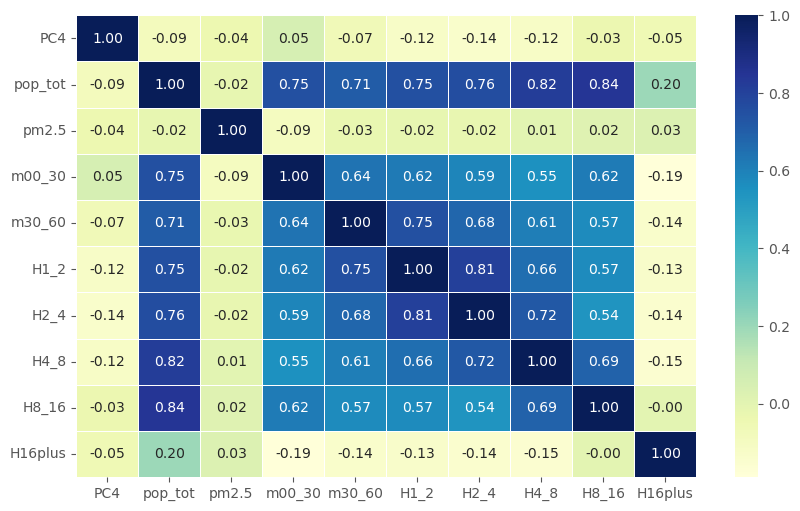

In [262]:
corr_matrix = df_zichtop_air_pollution.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="YlGnBu");

The correlation matrix demonstrates that PC4, m00_30 and m30_60 have the highest coreelation with our target column pm2.5.

<h4><font color=mediumvioletred>Get number of people in zip code 5611 on 2021-09-25 </font></h4>

In [263]:
people_air_quality_area = df_zichtop_air_pollution[(df_zichtop_air_pollution["PC4"] == 5611) & (df_zichtop_air_pollution["date"] == "2021-09-25")]
people_air_quality_area.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
20,5611,2021-09-25 20:00:00,6183,15.954722,652.0,65.0,117.0,1291.0,1631.0,1448.0,979.0,2021-09-25,20:00:00
4,5611,2021-09-25 04:00:00,1464,6.389200,56.0,0.0,14.0,28.0,28.0,155.0,1183.0,2021-09-25,04:00:00
0,5611,2021-09-25 00:00:00,1438,4.531522,155.0,0.0,0.0,0.0,0.0,77.0,1206.0,2021-09-25,00:00:00
9,5611,2021-09-25 09:00:00,5693,9.297590,631.0,166.0,880.0,963.0,913.0,1029.0,1111.0,2021-09-25,09:00:00
14,5611,2021-09-25 14:00:00,8035,4.974612,995.0,357.0,699.0,1445.0,2020.0,1492.0,1027.0,2021-09-25,14:00:00


<h4><font color=mediumvioletred>Visualize number of people in zip code 5611 on 2021-09-25 </font></h4>

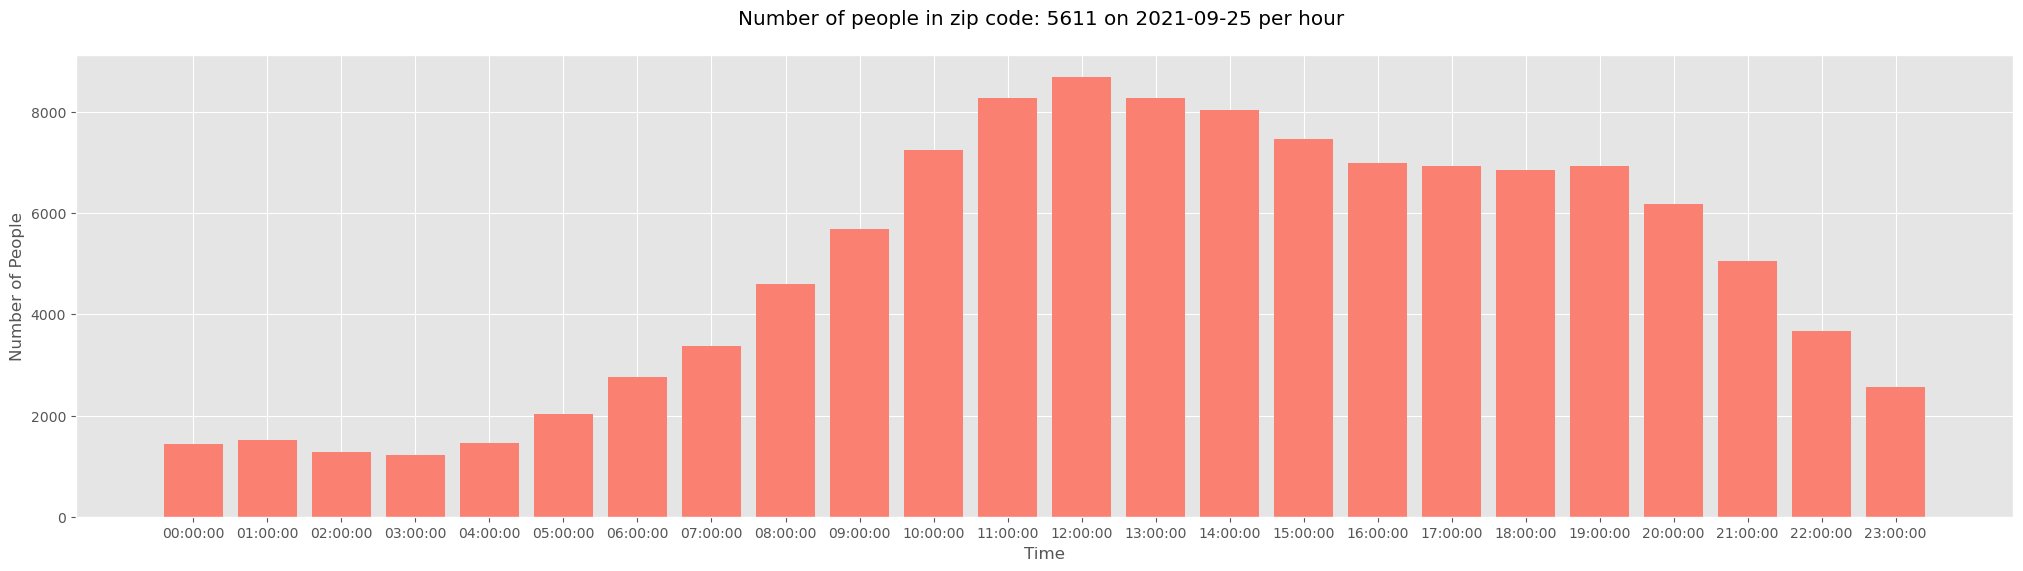

In [264]:
fig, ax = plt.subplots(figsize=(25, 6))
# Plot the data
scatter = ax.bar(list(people_air_quality_area["time"]),
                list(people_air_quality_area["pop_tot"]),
                color="salmon");

# Customize the plot
ax.set(title="Number of people in zip code: 5611 on 2021-09-25 per hour \n",
      xlabel="Time",
      ylabel="Number of People");

The bar chart shows that on September 25, 2021, the population of zip code 5611 starts increasing at 5 AM, peaks at 12 PM, and then begins to decline around 7 PM.

<h4><font color=mediumvioletred> Get maximum number of people per zip code </font></h4>

In [265]:
max_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg("max").reset_index()
max_people.head()

,PC4,pop_tot
0,5611,11617
1,5612,10250
2,5613,5925
3,5614,3504
4,5615,4408


<h4><font color=mediumvioletred> Visualize maximum number of people per zip code </font></h4>

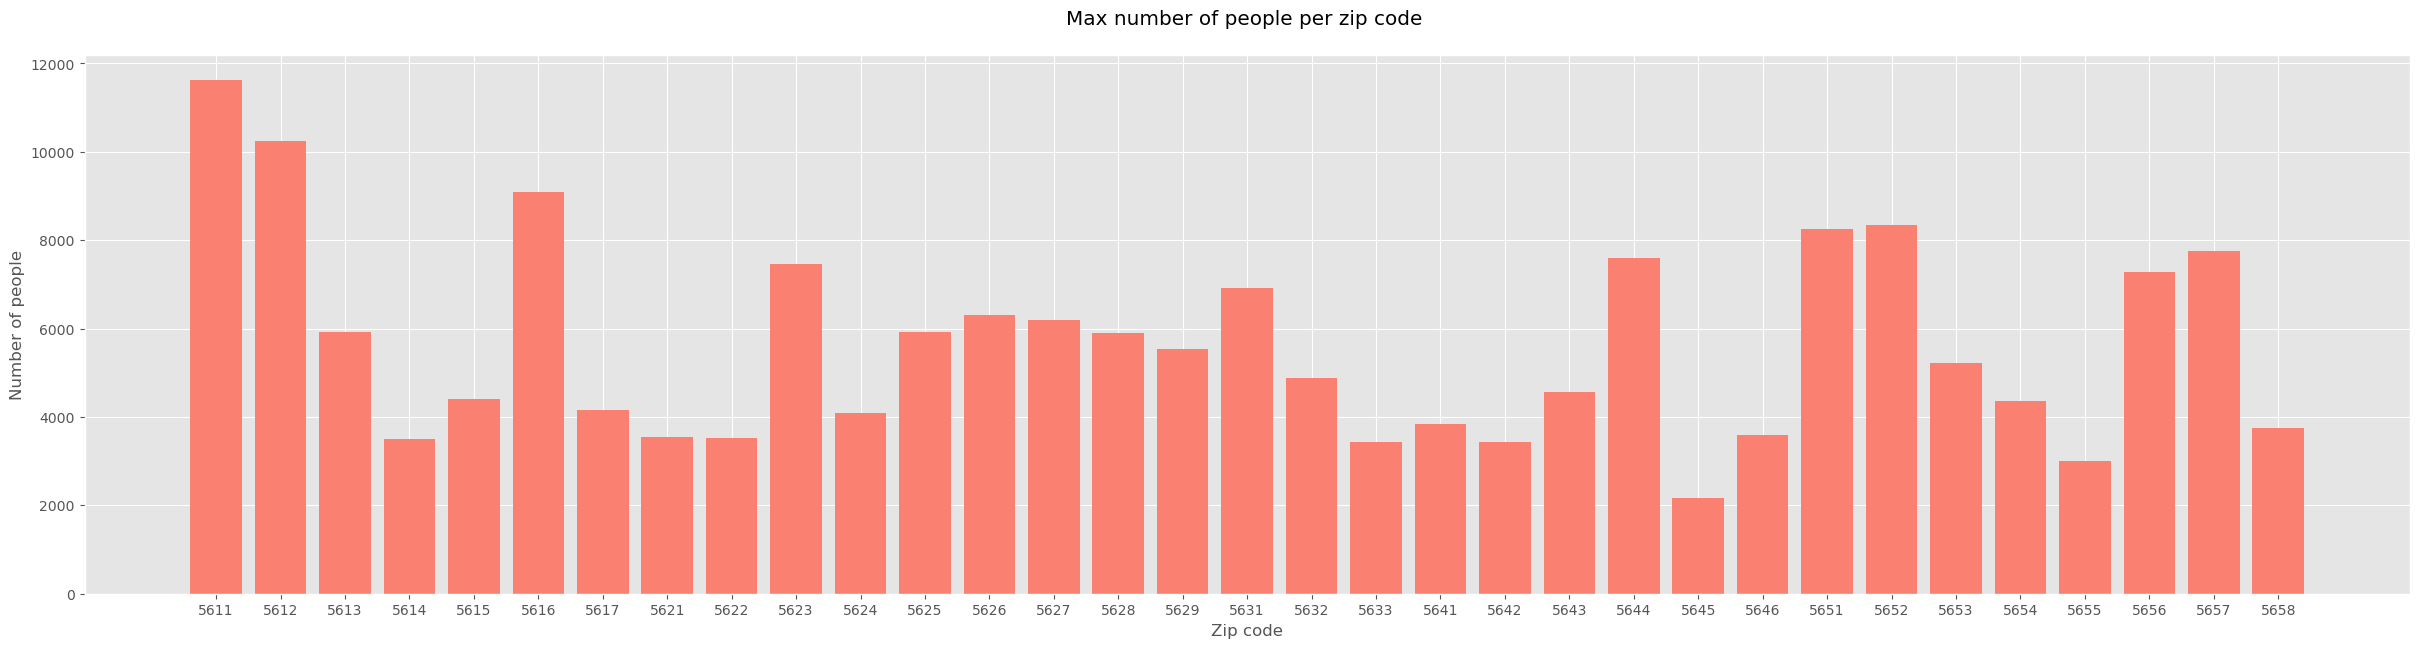

In [266]:
fig, ax = plt.subplots(figsize=(30, 7))
# Plot the data
scatter = ax.bar(max_people["PC4"].astype(str),
                max_people["pop_tot"],
                color="salmon");

# Customize the plot
ax.set(title="Max number of people per zip code \n",
      xlabel="Zip code",
      ylabel="Number of people");

According to the graph, zip codes 5611, 5612 and 5616 have the highest number of people. These areas are at the city center of Eindhoven, so that is to be expected.

<h4><font color=mediumvioletred> Get maximum, average and minimum number of people per zip code </font></h4>

In [267]:
max_mean_min_people = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_people.head()

,PC4,max,min,mean
0,5611,11617,708,4676.526515
1,5612,10250,737,4052.258333
2,5613,5925,537,2504.754545
3,5614,3504,217,1509.311364
4,5615,4408,394,1933.862121


<h4><font color=mediumvioletred> Visualize maximum, average and minimum number of people per zip code </font></h4>

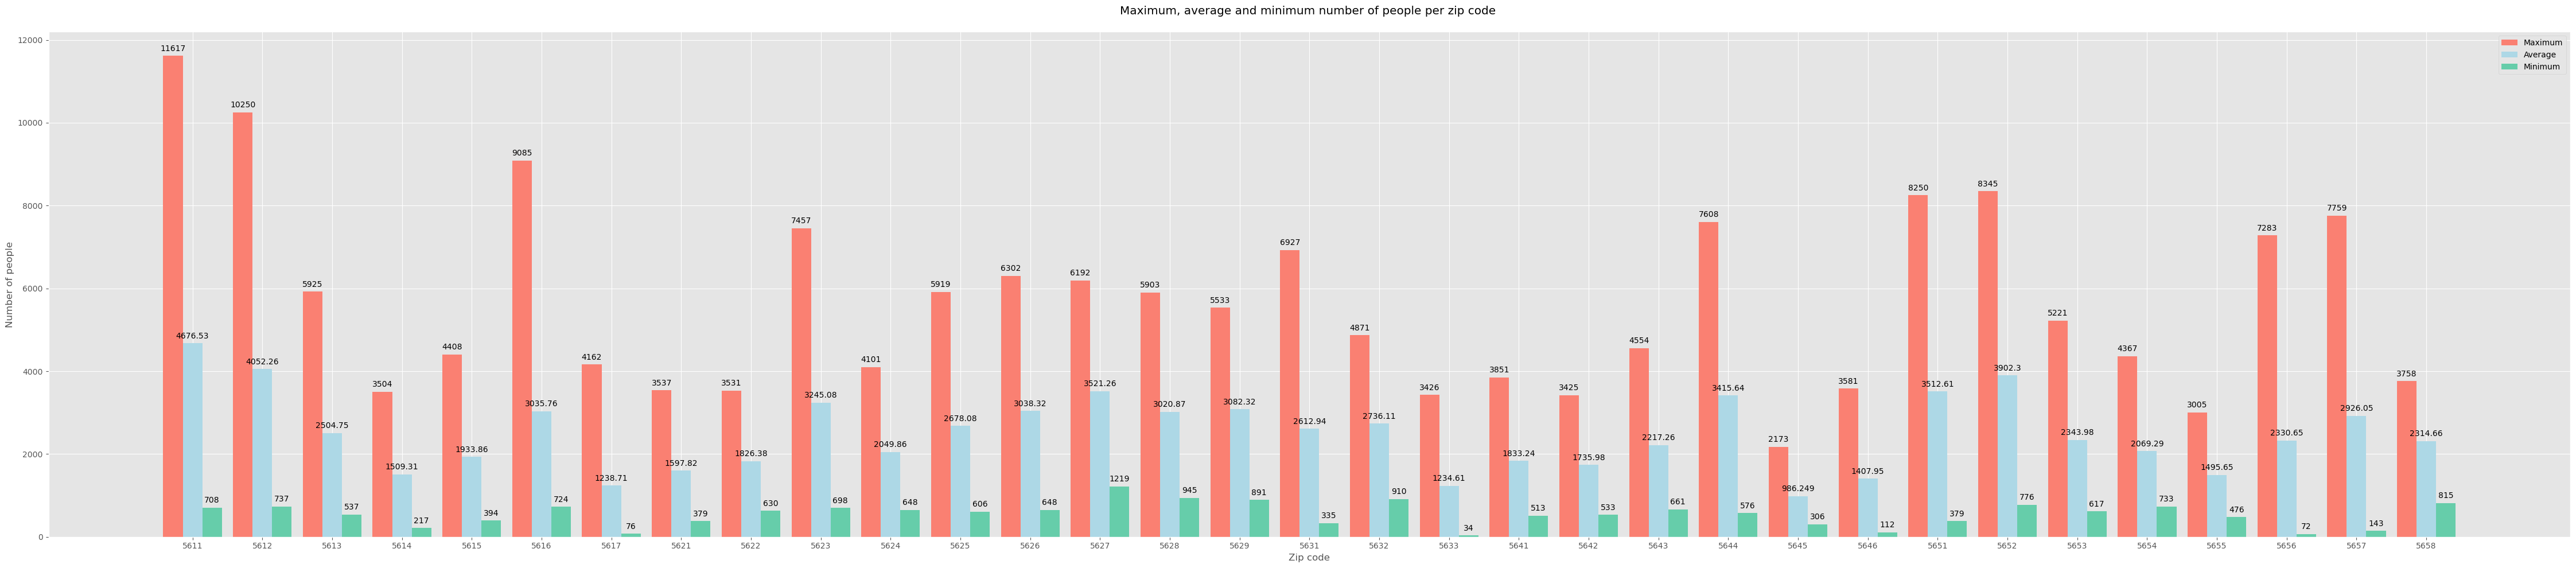

In [268]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_people["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, max_mean_min_people["max"], width, label="Maximum", color="salmon")
rects2 = ax.bar(x, max_mean_min_people["mean"], width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, max_mean_min_people["min"], width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Number of people")
ax.set_xlabel("Zip code")
ax.set_title("Maximum, average and minimum number of people per zip code \n")
ax.set_xticks(x, max_mean_min_people["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

plt.show()

The graph shows that zip codes 5611, 5612 and 5616 have the highest number of people, while zip codes 5633, 5656, 5617 have the lowest number of people.

<h4><font color=mediumvioletred> Get number of people vs. air quality </font></h4>

In [269]:
# get data for zip code 5611 on 2021-09-25
people_air_quality_area.head(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
0,5611,2021-09-25 00:00:00,1438,4.531522,155.0,0.0,0.0,0.0,0.0,77.0,1206.0,2021-09-25,00:00:00
1,5611,2021-09-25 01:00:00,1516,3.434374,130.0,0.0,0.0,0.0,29.0,72.0,1285.0,2021-09-25,01:00:00
2,5611,2021-09-25 02:00:00,1283,4.274056,44.0,0.0,0.0,0.0,15.0,73.0,1151.0,2021-09-25,02:00:00
3,5611,2021-09-25 03:00:00,1223,5.396931,14.0,0.0,0.0,14.0,14.0,86.0,1095.0,2021-09-25,03:00:00
4,5611,2021-09-25 04:00:00,1464,6.389200,56.0,0.0,14.0,28.0,28.0,155.0,1183.0,2021-09-25,04:00:00


<h4><font color=mediumvioletred> Visualize number of people vs. air quality </font></h4>

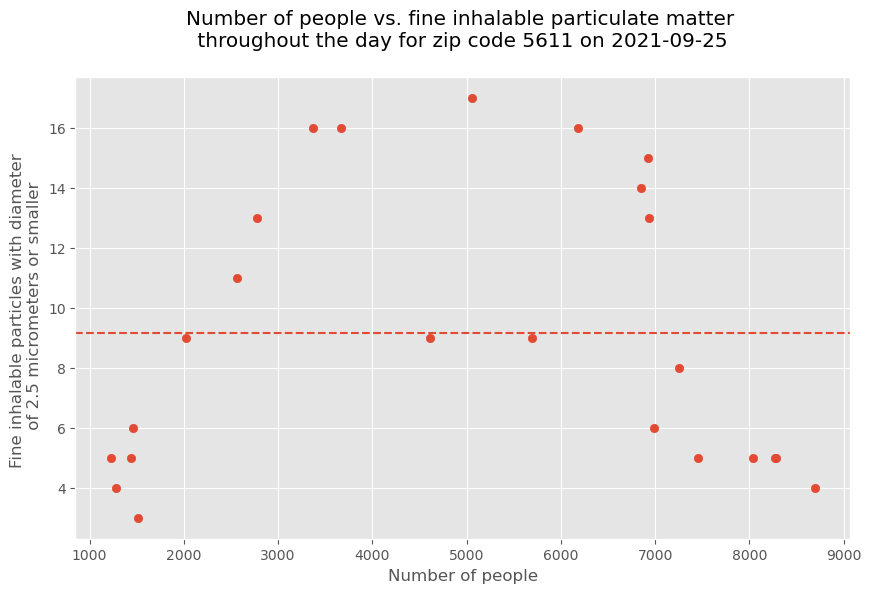

In [270]:
# Number of people vs. fine particulate matter in a day in a specific area
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
scatter = ax.scatter(x=people_air_quality_area["pop_tot"],
                    y=round(people_air_quality_area["pm2.5"]),
                    cmap="winter"); # color map: this changes the color scheme

# Customize the plot
ax.set(title="Number of people vs. fine inhalable particulate matter \n throughout the day for zip code 5611 on 2021-09-25 \n",
      xlabel="Number of people",
      ylabel="Fine inhalable particles with diameter \n of 2.5 micrometers or smaller");

# Add a horizontal line
ax.axhline(people_air_quality_area["pm2.5"].mean(),
          linestyle="--");

The graph demonstrates a positive correlation between the population and pm2.5 in zip code 5611 on September 25, 2021.

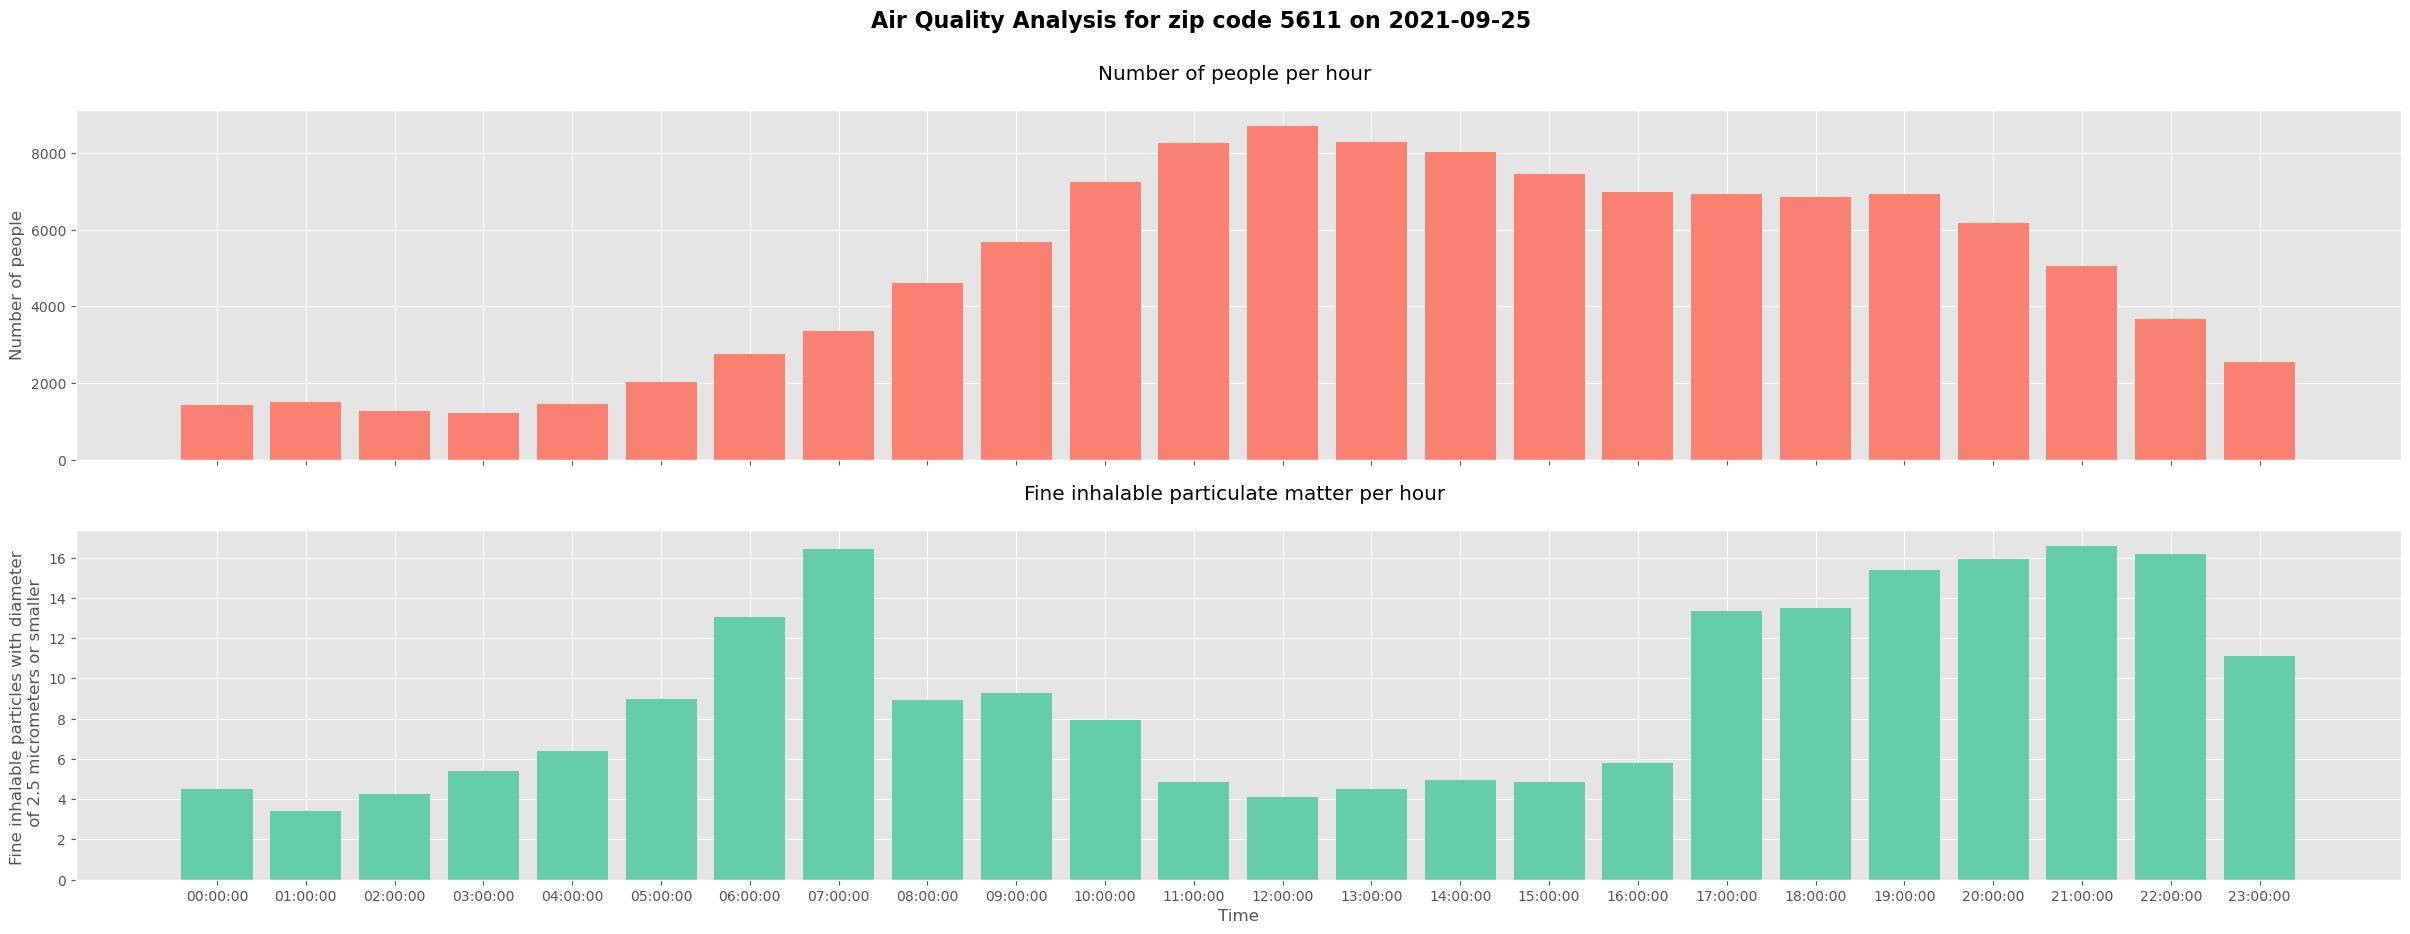

In [271]:
# Subplot of number of people, pollution, time
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 10),
                                sharex=True)

# Add data to ax0
ax0.bar(people_air_quality_area["time"], people_air_quality_area["pop_tot"], color="salmon");
# Add data to ax1
ax1.bar(people_air_quality_area["time"], people_air_quality_area["pm2.5"], color="mediumaquamarine");

# Customize ax0
ax0.set(title="Number of people per hour \n",
      ylabel="Number of people");

# Customize ax1
ax1.set(title="Fine inhalable particulate matter per hour \n",
        xlabel="Time",
        ylabel="Fine inhalable particles with diameter \n of 2.5 micrometers or smaller");

# Add a title to the figure
fig.suptitle("Air Quality Analysis for zip code 5611 on 2021-09-25", fontsize=16, fontweight="bold");

The bar chart illustrates that the pm2.5 in zip code 5611 on September 25, 2021 increases during the rush hours because of traffic, and decreases and stabilizes during the off-peak hours.

<h4><font color=mediumvioletred> Get maximum, average and minimum fine inhalable particulate matter per zip code </font></h4>

In [272]:
# Get daily average of pm2.5 per zip code
average_pm_per_day = df_zichtop_air_pollution.groupby(["PC4", "date"])["pm2.5"].agg({"mean"}).reset_index()

# Get maximum, average and minimum of pm2.5 per zip code
max_mean_min_pm = average_pm_per_day.groupby(["PC4"])["mean"].agg(["max", "min", "mean"]).reset_index()
max_mean_min_pm.head()

,PC4,max,min,mean
0,5611,36.353814,2.800860,11.384660
1,5612,36.713622,2.803116,11.319719
2,5613,33.850463,2.651556,10.836317
3,5614,33.032114,2.573862,10.658091
4,5615,35.662240,2.660535,11.044525


<h4><font color=mediumvioletred> Visualize maximum, average and minimum fine inhalable particulate matter per zip code </font></h4>

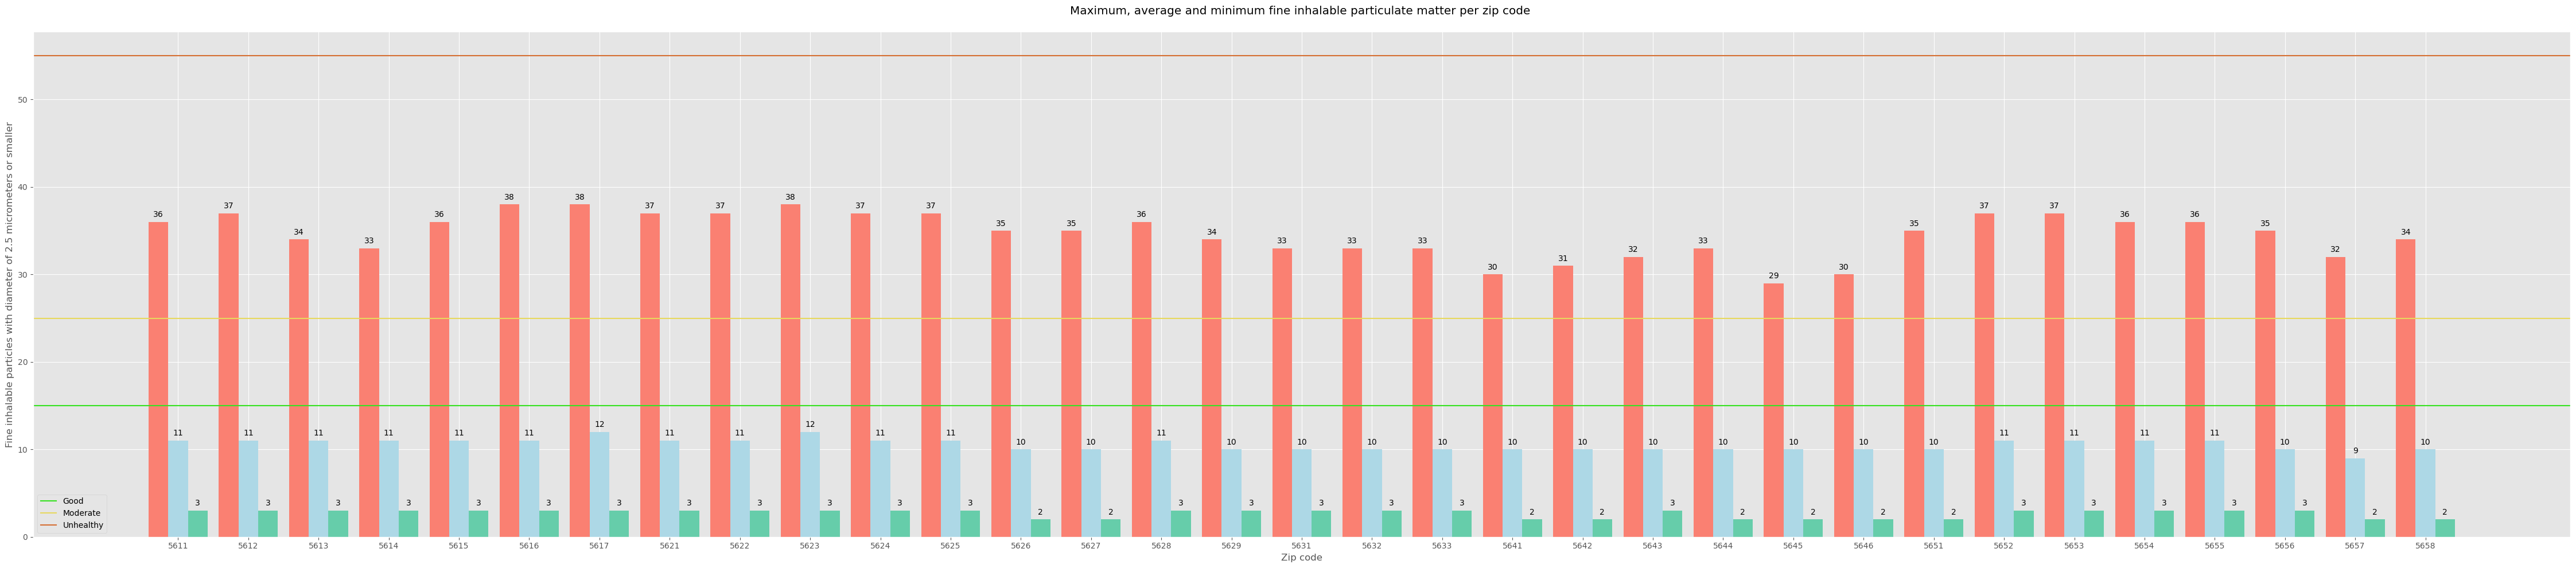

In [273]:
fig, ax = plt.subplots(figsize=(45, 10))

x = np.arange(len(max_mean_min_pm["PC4"]))  # the label locations
width = 0.28  # the width of the bars

# Plot the data
rects1 = ax.bar(x - width, round(max_mean_min_pm["max"]), width, label="Maximum", color="salmon")
rects2 = ax.bar(x, round(max_mean_min_pm["mean"]), width, label="Average", color="lightblue")
rects3 = ax.bar(x + width, round(max_mean_min_pm["min"]), width, label="Minimum", color="mediumaquamarine")

# Customize the plot
ax.set_ylabel("Fine inhalable particles with diameter of 2.5 micrometers or smaller")
ax.set_xlabel("Zip code")
ax.set_title("Maximum, average and minimum fine inhalable particulate matter per zip code \n")
ax.set_xticks(x, max_mean_min_pm["PC4"])
ax.legend()

ax.bar_label(rects1, padding=4)
ax.bar_label(rects2, padding=4)
ax.bar_label(rects3, padding=4)

fig.tight_layout()

# adding air quality limits
good_limit = [15]
moderate_limit = [25]
unhealthy_limit = [55]

plt.axhline(y = good_limit, color = '#36e221', linestyle = '-')
plt.axhline(y = moderate_limit, color = '#e7d85d', linestyle = '-')
plt.axhline(y = unhealthy_limit, color = '#d56f33', linestyle = '-')
plt.legend(['Good', 'Moderate', 'Unhealthy'])

plt.show()

The graph indicates, that for each zip code the average and minimum pm2.5 levels are good while the maximum pm2.5 levels are unhealthy.

![title](images/pm2.5_chart.jpg)

<h4><font color=mediumvioletred>Calculate number of people per hour </font></h4>

In [274]:
# Get specific columns
people_per_hour = df_zichtop_air_pollution.iloc[:, [0, 3, 4, 5, 11, 12]].copy()
# Calculate number of people per hour
people_per_hour["people_number"] = people_per_hour["m00_30"] + people_per_hour["m30_60"]

people_per_hour.head(5)

,PC4,pm2.5,m00_30,m30_60,date,time,people_number
0,5611,4.531522,155.0,0.0,2021-09-25,00:00:00,155.0
1,5611,3.434374,130.0,0.0,2021-09-25,01:00:00,130.0
2,5611,4.274056,44.0,0.0,2021-09-25,02:00:00,44.0
3,5611,5.396931,14.0,0.0,2021-09-25,03:00:00,14.0
4,5611,6.389200,56.0,0.0,2021-09-25,04:00:00,56.0


<h4><font color=mediumvioletred> Get number of people and average fine particulate matter (pm2.5) per day and area </font></h4>

In [275]:
# Calculate people number (sum) and pm2.5 (average) per day
people_pollution_per_day_area = people_per_hour.groupby(["PC4", "date"]).agg({"people_number": "sum", "pm2.5": "mean"}).reset_index()
# Round to 2 decimal places
people_pollution_per_day_area = people_pollution_per_day_area.round(decimals=2)

people_pollution_per_day_area.head(5)

,PC4,date,people_number,pm2.5
0,5611,2021-09-25,16501.0,9.16
1,5611,2021-09-26,13175.0,8.11
2,5611,2021-09-27,24414.0,6.65
3,5611,2021-09-28,20980.0,5.89
4,5611,2021-09-29,21242.0,3.48


<h4><font color=mediumvioletred> Visualize the distribution of population </font></h4>

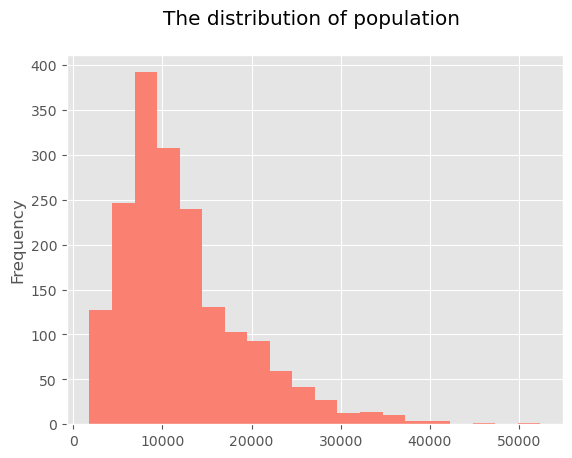

In [276]:
people_pollution_per_day_area["people_number"].plot.hist(bins=20, 
                                                         title="The distribution of population \n", 
                                                         color="salmon");

After visualizing the distribution of the population, we can see that there are a few outliers, starting around 40000.

<h4><font color=mediumvioletred> Visualize the distribution of the fine particulate matter (pm2.5) </font></h4>

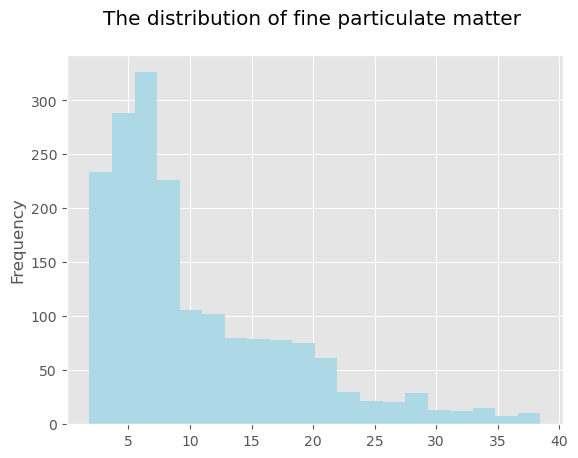

In [277]:
people_pollution_per_day_area["pm2.5"].plot.hist(bins=20,
                                                title="The distribution of fine particulate matter \n", 
                                                color="lightblue");

We can observe that there are a few outliers in the graph above, starting around 35.

<h4><font color=mediumvioletred> Get number of people and fine particulate matter (pm2.5) for multiple weeks in zip code 5611 </font></h4>

In [278]:
people_pollution_multiple_weeks_5611 = people_pollution_per_day_area[(people_pollution_per_day_area["date"] >= "2021-11-01") & 
                                                                    (people_pollution_per_day_area["date"] < "2021-11-18") & 
                                                                    (people_pollution_per_day_area["PC4"] == 5611)]
people_pollution_multiple_weeks_5611.sample(5)

,PC4,date,people_number,pm2.5
52,5611,2021-11-16,9795.0,36.35
44,5611,2021-11-08,11474.0,17.89
43,5611,2021-11-07,8005.0,5.41
49,5611,2021-11-13,7949.0,9.84
51,5611,2021-11-15,10391.0,19.92


<h4><font color=mediumvioletred> Visualize number of people for multiple weeks in zip code 5611 </font></h4>

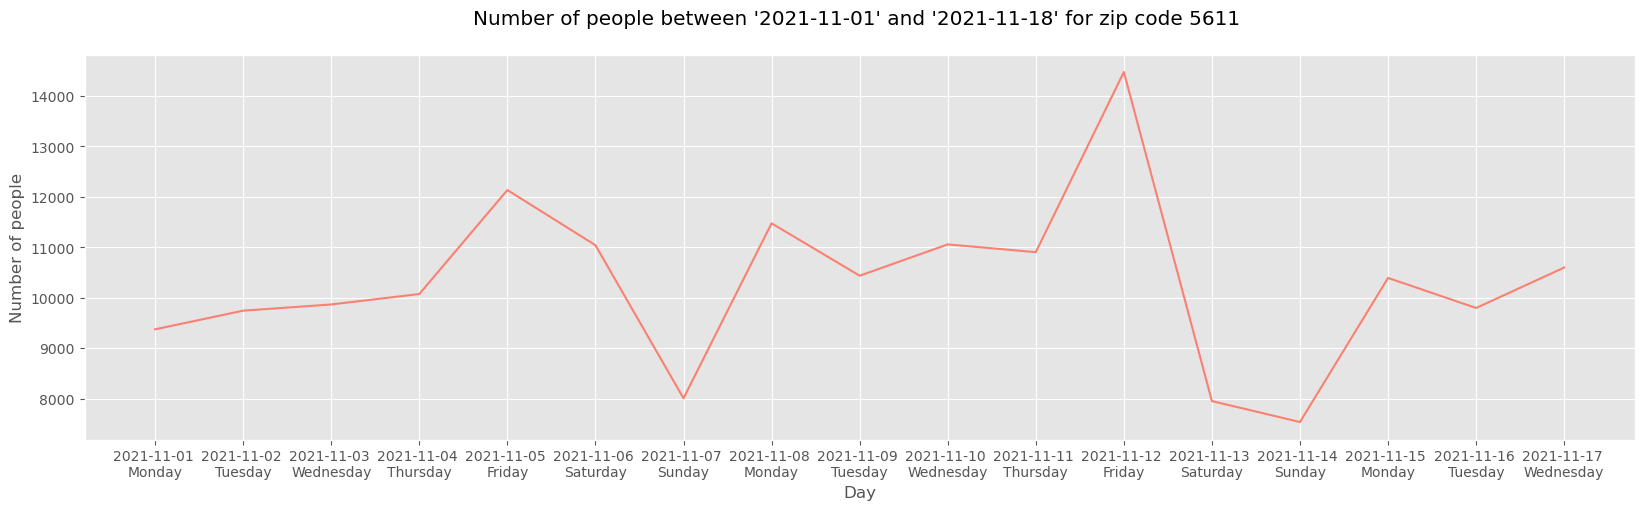

In [279]:
plt.figure(figsize = (20 ,5))

plt.plot(people_pollution_multiple_weeks_5611["date"] + " \n" + pd.DatetimeIndex(people_pollution_multiple_weeks_5611["date"]).day_name(), 
         people_pollution_multiple_weeks_5611["people_number"], color="salmon")
 
# Adding Title to the Plot
plt.title("Number of people between '2021-11-01' and '2021-11-18' for zip code 5611 \n")

# Setting the X and Y labels
plt.xlabel("Day")
plt.ylabel("Number of people")
  
plt.show()

After looking at the population for a few weeks, we can notice a pattern. The number of people balances during the week; it begins to rise on Thursday and peaks on Friday before falling on Saturday, reaching its lowest point on Sunday, and then rising once more on Monday.

<h4><font color=mediumvioletred> Visualize the distribution of population using Boxplot and Histogram</font></h4>

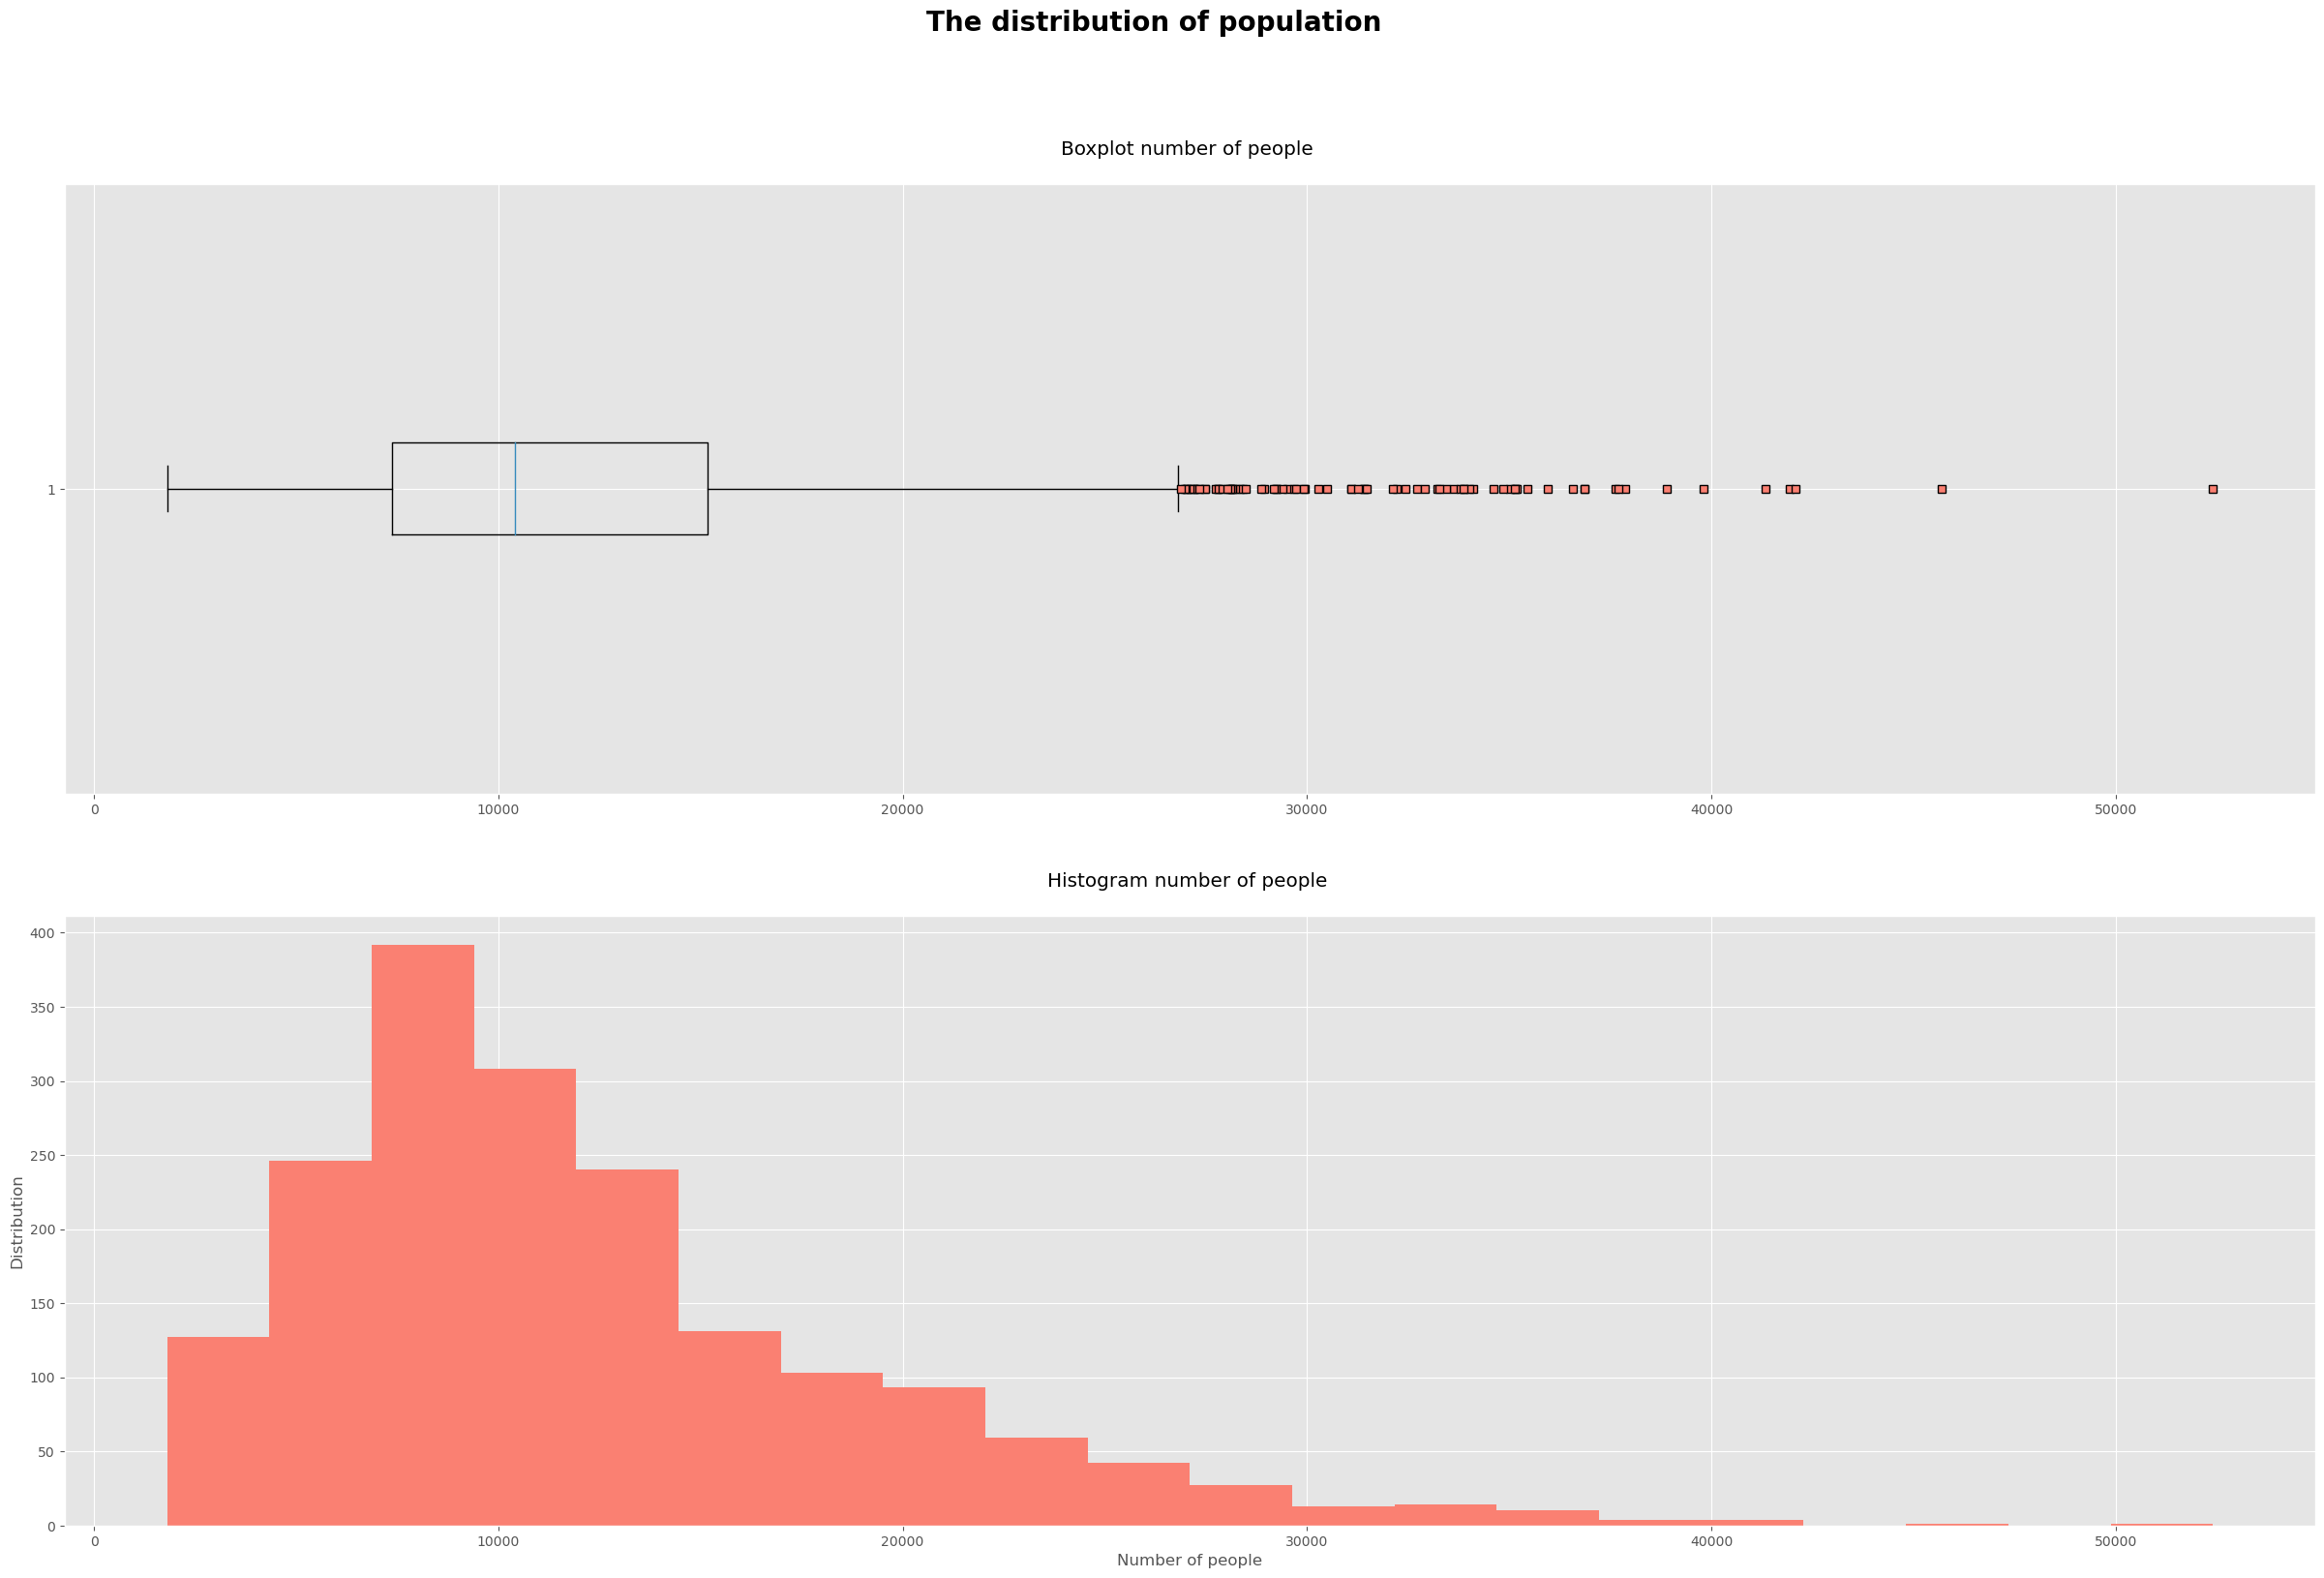

In [280]:
# Subplot of number of people distribution
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 18),
                                sharex=False)

# Add data to ax0
red_square = dict(markerfacecolor='salmon', marker='s')
ax0.boxplot(people_pollution_per_day_area["people_number"], vert=False, flierprops=red_square);
# Add data to ax1
ax1.hist(people_pollution_per_day_area["people_number"], bins=20, color="salmon");

# Customize ax0
ax0.set(title="Boxplot number of people \n");

# Customize ax1
ax1.set(title="Histogram number of people \n",
        xlabel="Number of people",
        ylabel="Distribution");

# Add a title to the figure
fig.suptitle("The distribution of population", fontsize=20, fontweight="bold");

From the graphs, we can derive that there are a few outliers, starting around 27000.

<h4><font color=mediumvioletred> Visualize the distribution of fine particulate matter using Boxplot and Histogram</font></h4>

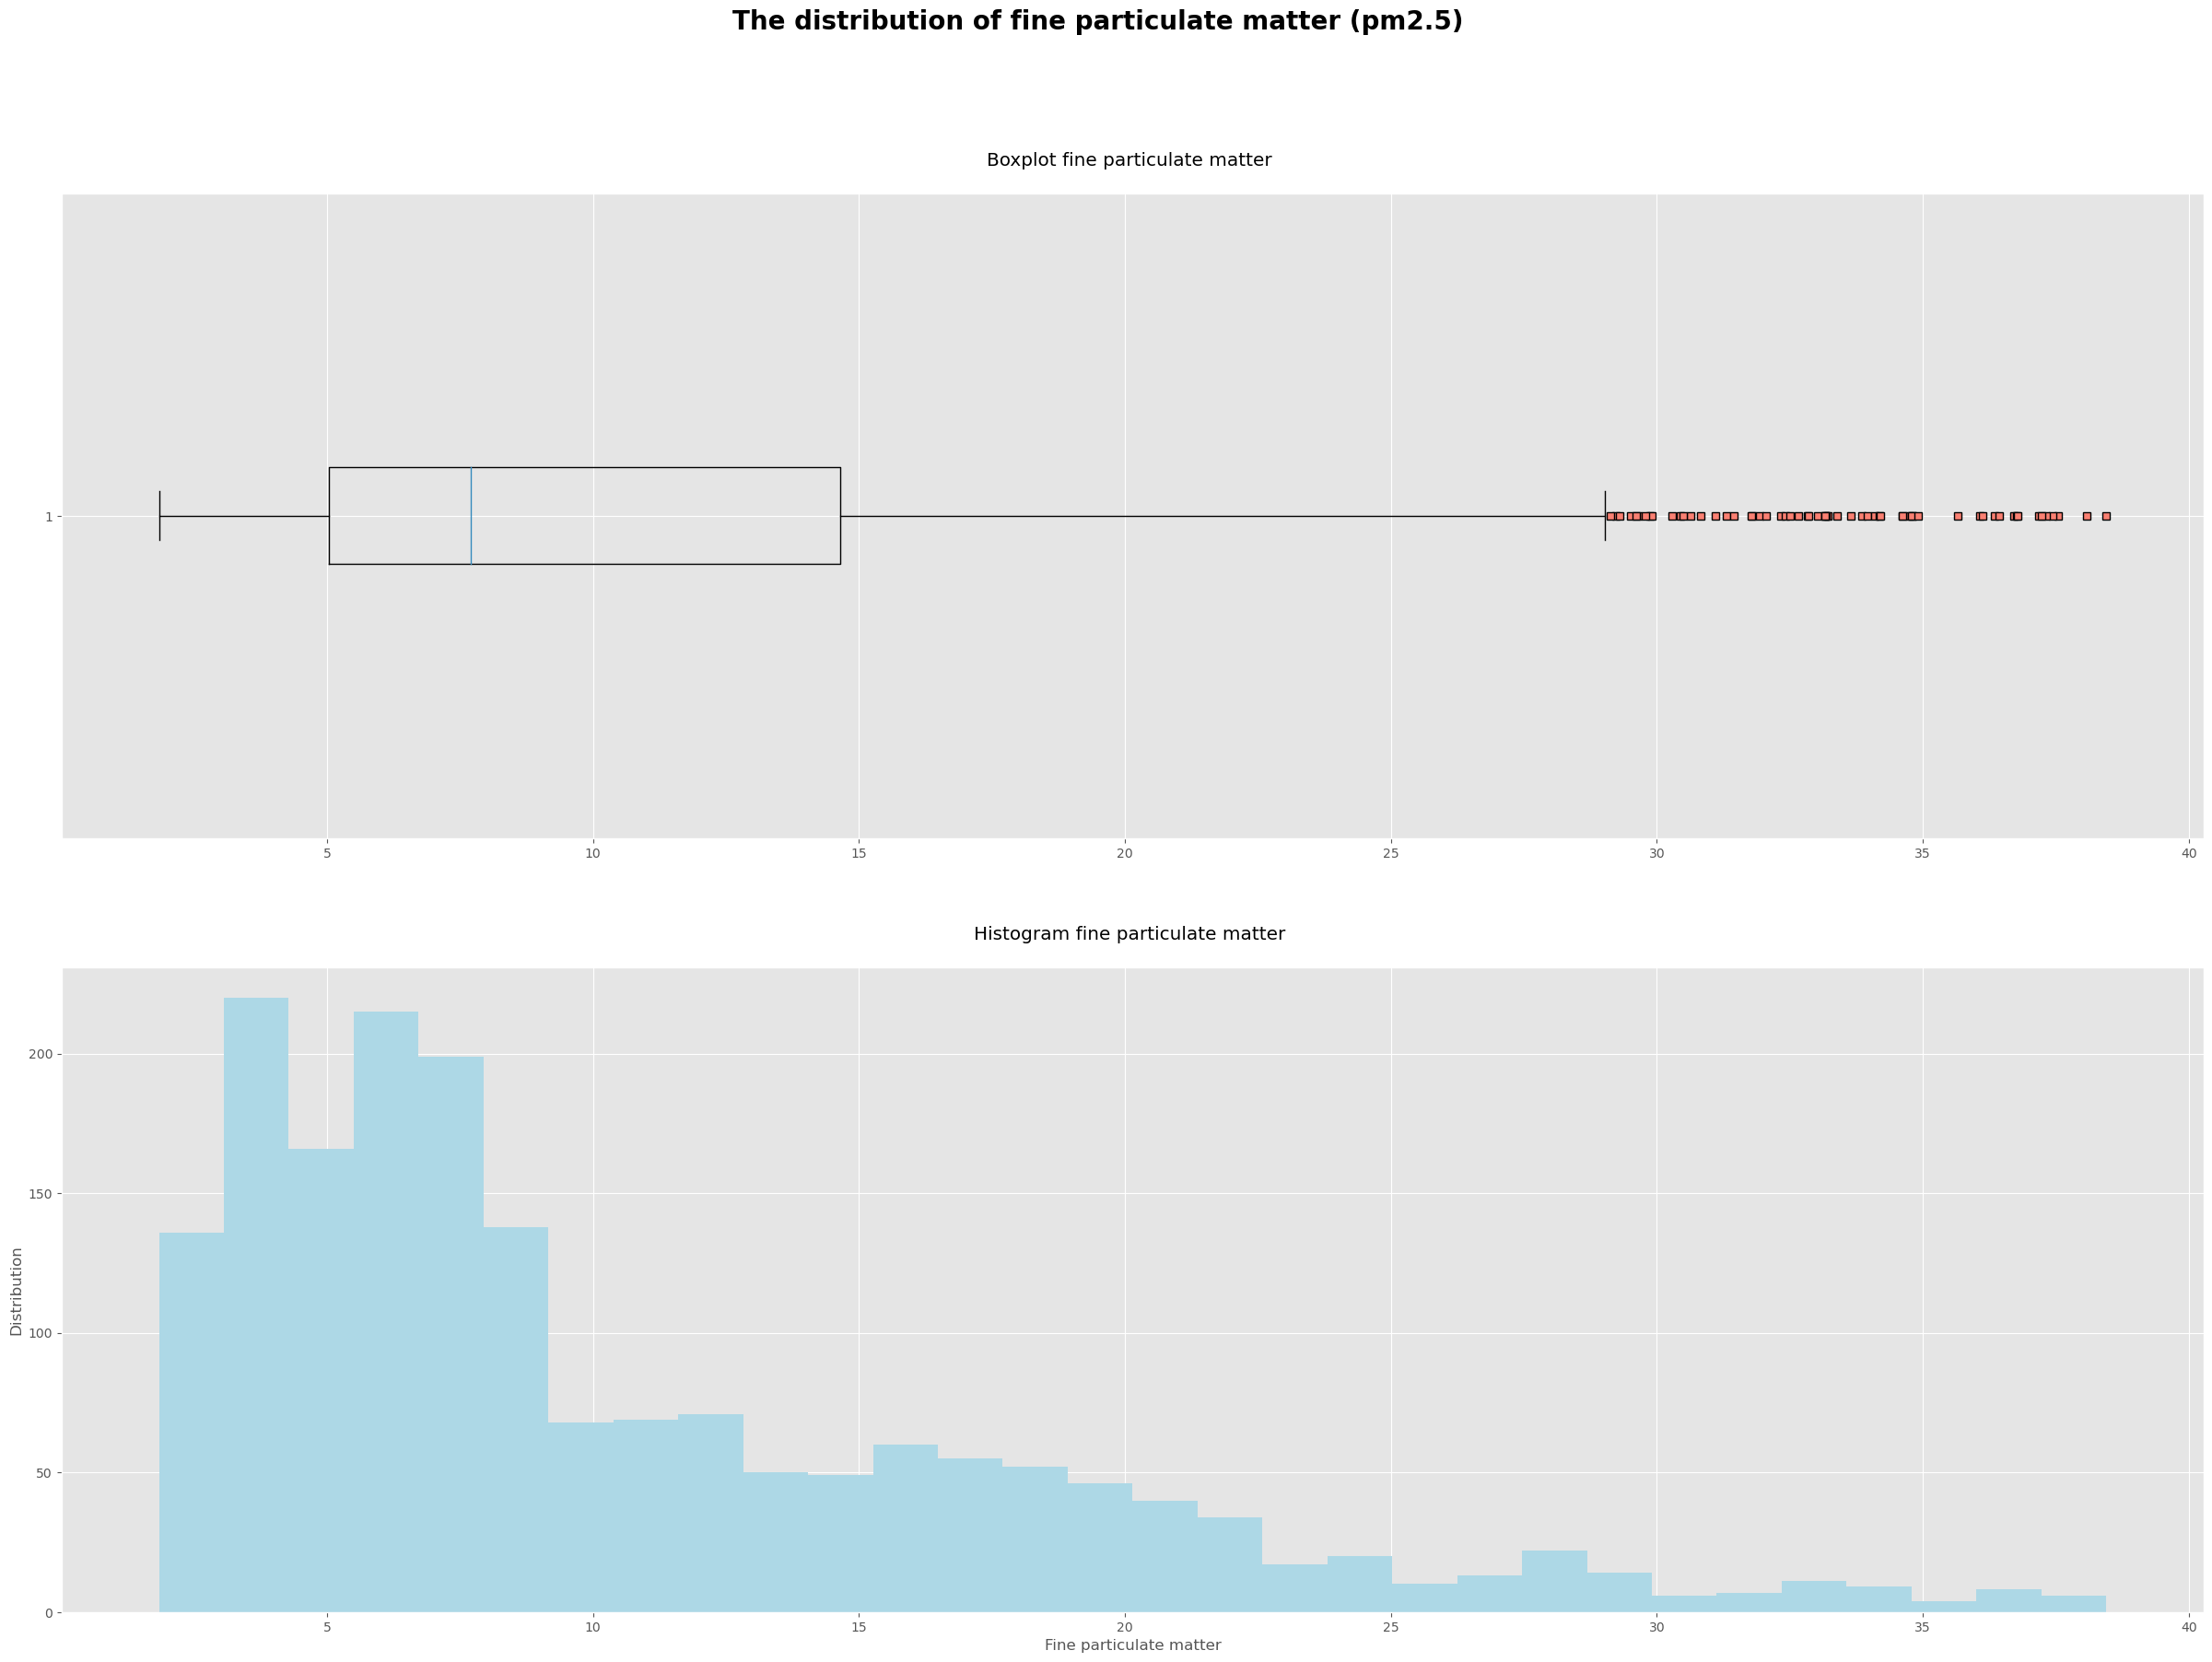

In [281]:
# Subplot of number of people distribution
fig, (ax0, ax1) = plt.subplots(nrows=2,
                                ncols=1,
                                figsize=(30, 20),
                                sharex=False)

# Add data to ax0
red_square = dict(markerfacecolor='salmon', marker='s')
ax0.boxplot(people_pollution_per_day_area["pm2.5"], vert=False, flierprops=red_square);
# Add data to ax1
ax1.hist(people_pollution_per_day_area["pm2.5"], bins=30, color="lightblue");

# Customize ax0
ax0.set(title="Boxplot fine particulate matter \n");

# Customize ax1
ax1.set(title="Histogram fine particulate matter \n",
        xlabel="Fine particulate matter",
        ylabel="Distribution");

# Add a title to the figure
fig.suptitle("The distribution of fine particulate matter (pm2.5)", fontsize=20, fontweight="bold");

From the graphs, we can derive that there are a few outliers, starting around 28.

<h4><font color=mediumvioletred> Visualize the population vs fine particulate matter (pm2.5) per area</font></h4>

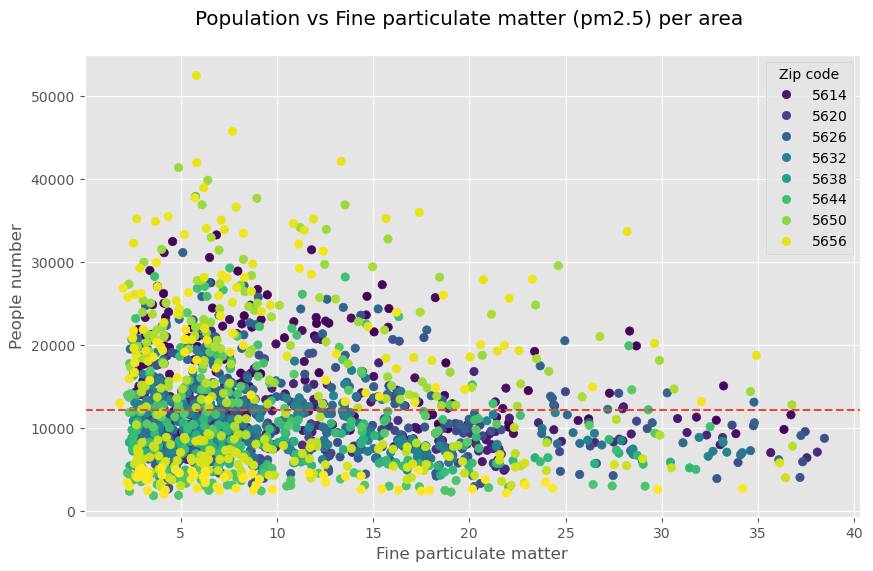

In [282]:
# OO method from scratch
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the data
scatter = ax.scatter(x=people_pollution_per_day_area["pm2.5"],
                    y=people_pollution_per_day_area["people_number"],
                    c=people_pollution_per_day_area["PC4"]);

# Customize the plot
ax.set(title="Population vs Fine particulate matter (pm2.5) per area \n",
      xlabel="Fine particulate matter",
      ylabel="People number");

# Add a legend
ax.legend(*scatter.legend_elements(), title="Zip code");

# Add a horizontal line
ax.axhline(people_pollution_per_day_area["people_number"].mean(),
          linestyle="--");

The above scatter plot confirms our previous findings, that both the people number and fine particulate matter have some outliers which need to be handled in order to produce an accurate model.

<h4><font color=mediumvioletred>Specify country code in Pgeocode library </font></h4>

In [283]:
nomi = pgeocode.Nominatim('nl')

<h4><font color=mediumvioletred>Get postal code information for zip code 5621 </font></h4>

In [284]:
nomi.query_postal_code("5621")

postal_code                5621
country_code                 NL
place_name            Eindhoven
state_name        Noord-Brabant
state_code                    6
county_name           Eindhoven
county_code                 772
community_name              NaN
community_code              NaN
latitude                51.4549
longitude                 5.457
accuracy                    6.0
Name: 0, dtype: object

<h4><font color=mediumvioletred>Get sample of of zichtop air pollution dataframe </font></h4>

In [285]:
df_zichtop_air_pollution.sample(5)

,PC4,date_time,pop_tot,pm2.5,m00_30,m30_60,H1_2,H2_4,H4_8,H8_16,H16plus,date,time
12444,5623,2021-10-18 12:00:00,6179,9.944092,1501.0,297.0,419.0,559.0,1501.0,1274.0,628.0,2021-10-18,12:00:00
36291,5653,2021-10-22 03:00:00,1094,2.963867,116.0,0.0,0.0,0.0,0.0,233.0,745.0,2021-10-22,03:00:00
5993,5615,2021-10-24 17:00:00,1967,8.536015,583.0,24.0,49.0,146.0,340.0,510.0,315.0,2021-10-24,17:00:00
31882,5646,2021-10-03 10:00:00,2047,3.943848,982.0,55.0,27.0,355.0,82.0,136.0,410.0,2021-10-03,10:00:00
28438,5643,2021-10-24 22:00:00,1377,6.421517,57.0,19.0,0.0,0.0,96.0,172.0,1033.0,2021-10-24,22:00:00


<h4><font color=mediumvioletred>Create a new dataframe containing unique zip codes </font></h4>

In [286]:
zipcodes = pd.DataFrame({"PC4": df_zichtop_air_pollution["PC4"].unique()})
zipcodes.head(5)

,PC4
0,5611
1,5612
2,5613
3,5614
4,5615


<h4><font color=mediumvioletred>Add latitude, longitude data to the zip codes dataframe </font></h4>

In [287]:
# add latitude, longitude data to the dataframe
zipcodes["latitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
zipcodes["longitude"] = zipcodes["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [288]:
zipcodes["PC4"] = zipcodes["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of zip codes </font></h4>

In [289]:
zipcodes.sample(5)

,PC4,latitude,longitude
18,5633,51.4899,5.4954
23,5645,51.4242,5.5109
22,5644,51.4183,5.4887
7,5621,51.4549,5.4570
1,5612,51.4484,5.4727


<h4><font color=mediumvioletred>Plot the map with the latitude, longitude and zip code in Eindhoven</font></h4>

In [290]:
fig = px.scatter_mapbox(zipcodes, 
                        title="Eindhoven map with latitude, longitude and zip code", 
                        lat="latitude", 
                        lon="longitude", 
#                         text="PC4", 
                        hover_name="PC4", 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>Get min and max number of people per area</font></h4>

In [291]:
min_max_people_per_area = df_zichtop_air_pollution.groupby(["PC4"])["pop_tot"].agg(["max", "min"]).rename(columns={'max': 'max_number_people', "min": "min_number_people"}).reset_index()
min_max_people_per_area.head(5)

,PC4,max_number_people,min_number_people
0,5611,11617,708
1,5612,10250,737
2,5613,5925,537
3,5614,3504,217
4,5615,4408,394


<h4><font color=mediumvioletred>Add latitude, longitude data to the min_max_people_per_area dataframe </font></h4>

In [292]:
min_max_people_per_area["latitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
min_max_people_per_area["longitude"] = min_max_people_per_area["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [293]:
min_max_people_per_area["PC4"] = min_max_people_per_area["PC4"].astype("str")

<h4><font color=mediumvioletred>Get sample of min_max_people_per_area </font></h4>

In [294]:
min_max_people_per_area.sample(5)

,PC4,max_number_people,min_number_people,latitude,longitude
13,5627,6192,1219,51.4853,5.4440
11,5625,5919,606,51.4719,5.4754
3,5614,3504,217,51.4284,5.4921
29,5655,3005,476,51.4152,5.4399
15,5629,5533,891,51.4884,5.4734


<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zip code, minimum and maximum number of people in Eindhoven</font></h4>

In [295]:
fig = px.scatter_mapbox(min_max_people_per_area, 
                        title="Eindhoven map with latitude, longitude, zip code, maximum and minimum number of people", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        hover_data=["min_number_people"], 
                        color="max_number_people", 
                        size="max_number_people", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred>People vs. pollution on 25-09-2021 </font></h4>

In [296]:
# Calculate people number (sum) and pm2.5 (average) on 2021-09-25
people_pollution_per_day = people_per_hour[people_per_hour.date == "2021-09-25"].groupby(["PC4"]).agg({"people_number": "sum", "pm2.5": "mean"}).reset_index()
# Round to 2 decimal places
people_pollution_per_day = people_pollution_per_day.round(decimals=2)

people_pollution_per_day.head(5)

,PC4,people_number,pm2.5
0,5611,16501.0,9.16
1,5612,23022.0,9.18
2,5613,14987.0,8.56
3,5614,10039.0,8.45
4,5615,11540.0,8.97


<h4><font color=mediumvioletred>Add latitude, longitude data to the people_pollution_per_day dataframe </font></h4>

In [297]:
people_pollution_per_day["latitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[9])
people_pollution_per_day["longitude"] = people_pollution_per_day["PC4"].apply(lambda x: nomi.query_postal_code(x)[10])

<h4><font color=mediumvioletred>Convert PC4 column to a string so that the circles appear on the map </font></h4>

In [298]:
people_pollution_per_day["PC4"] = people_pollution_per_day["PC4"].astype("str")

<h4><font color=mediumvioletred>Plot the map with the latitude, longitude, zip code, number of people and fine inhalable particulate matter in Eindhoven</font></h4>

In [299]:
fig = px.scatter_mapbox(people_pollution_per_day, 
                        title="Number of people vs. fine inhalable particulate matter per zip code in Eindhoven on 25-09-2021", 
                        lat="latitude", 
                        lon="longitude", 
                        hover_name="PC4", 
                        color="pm2.5", 
                        size="people_number", 
                        color_continuous_scale=px.colors.diverging.balance, 
                        size_max=15, 
                        zoom=10, 
                        height=300)
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0, "t":30, "l":0, "b":0})
fig.show()

<h4><font color=mediumvioletred> Conclusion </font></h4>

After exploring and visualizing the zichtop dataset, we conclude that the only relevant columns to use in the following steps are  date, PC4 (zip code) and a new column called people_number (m00_30 + m30_60).

We need this new column because we want to group data per area and date and currently pop_tot column is the result of the sum of the following columns (m00_30, m30_60, H1_2, H2_4, H4_8, H8_16 and H16plus), so the same people are counted multiple times throughout the day and that will result in inaccurate number of people.

<h3><font color=steelblue>Meteo dataset</font></h3>

<h4><font color=mediumvioletred>Read CSV files and get meteo data sample</font></h4>

In [300]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_meteo = pd.read_csv("data/meteo.csv")
df_air_pollution = pd.read_csv("data/air_pollution.csv")
df_meteo.sample(10)

,date,PC4,wd,ws,blh,tcc,ssrd
86386,2021-11-11 10:00:00,5623,255.980316,2.361614,146.544388,0.963626,131.569141
143195,2021-05-07 11:00:00,5631,174.041656,4.517395,1315.937744,0.621967,710.358819
39593,2021-07-09 17:00:00,5615,184.567566,2.537384,1200.373535,0.564114,230.535017
196288,2021-05-29 16:00:00,5644,66.910049,3.304991,1523.643555,0.885807,415.483681
241144,2021-07-12 16:00:00,5653,316.093018,1.140266,330.576294,1.000000,158.091667
171860,2021-08-14 20:00:00,5641,126.756729,1.846108,41.945709,0.043643,0.000000
165925,2021-12-10 13:00:00,5633,321.178375,2.110833,490.006165,1.000000,55.300977
119703,2021-08-31 15:00:00,5627,95.861267,4.588155,882.609253,0.541131,378.080556
34775,2021-12-20 23:00:00,5614,359.699371,1.918576,87.345512,0.008116,0.000000
65964,2021-07-13 12:00:00,5621,104.667313,3.500505,465.735962,1.000000,215.231840


<h4><font color=mediumvioletred>Get air pollution data sample</font></h4>

In [301]:
df_air_pollution.sample(10)

,date,PC4,pm10,pm2.5,no2,no,so2
24437,2021-10-08 05:00:00,5629,13.455816,5.470156,45.655441,29.870315,16.194755
73900,2021-12-27 03:00:00,5624,16.061140,30.865100,31.206477,2.837157,0.919806
75458,2021-12-29 01:00:00,5623,17.298050,23.957640,25.432960,15.108047,2.303584
54005,2021-12-02 04:00:00,5617,18.351330,14.396934,9.516518,0.109181,0.974101
64425,2021-12-15 08:00:00,5625,27.915020,53.536140,26.900055,2.249005,2.818434
70196,2021-12-22 19:00:00,5642,31.161340,52.407340,46.438143,17.860842,5.189024
40662,2021-10-14 06:00:00,5651,20.703810,9.506160,30.356750,19.861065,6.291332
68604,2021-12-20 11:00:00,5642,28.520030,18.804270,12.332480,4.188246,1.280227
49285,2021-11-07 13:00:00,5656,7.870913,3.069547,10.388845,6.796957,1.548477
47217,2021-10-19 09:00:00,5655,7.794010,5.788624,28.141521,18.411740,6.807598


<h4><font color=mediumvioletred>Show all postal codes</font></h4>

In [302]:
df_meteo['PC4'].unique()

array([5611, 5612, 5613, 5614, 5615, 5616, 5617, 5621, 5622, 5623, 5624,
       5625, 5626, 5627, 5628, 5629, 5631, 5632, 5633, 5641, 5642, 5643,
       5644, 5645, 5646, 5651, 5652, 5653, 5654, 5655, 5656, 5657, 5658],
      dtype=int64)

The dataset contains data from 33 different postal code areas

<h4><font color=mediumvioletred>Show the shape of the meteo data</font></h4>

In [303]:
df_meteo.shape

(289080, 7)

<h4><font color=mediumvioletred>Show all datatypes of meteo data</font></h4>

In [304]:
df_meteo['date'] = pd.to_datetime(df_meteo['date'])
df_air_pollution['date'] = pd.to_datetime(df_air_pollution['date'])
df_meteo.dtypes

date    datetime64[ns]
PC4              int64
wd             float64
ws             float64
blh            float64
tcc            float64
ssrd           float64
dtype: object

<h4><font color=mediumvioletred>Filter meteo data on single postal code and get a sample</font></h4>

In [305]:
postalcode_df_meteo = df_meteo[df_meteo['PC4'] == 5611]
postalcode_df_meteo.sample(10)

,date,PC4,wd,ws,blh,tcc,ssrd
1055,2021-02-13 23:00:00,5611,327.073181,5.191962,400.412628,0.939731,0.000000
5782,2021-08-29 22:00:00,5611,88.202690,3.935829,517.058105,0.622267,0.000000
1373,2021-02-27 05:00:00,5611,77.250725,1.630628,197.426208,1.000000,0.000000
5893,2021-09-03 13:00:00,5611,32.778580,2.865788,1064.943115,0.085057,661.957153
2396,2021-04-10 20:00:00,5611,72.835953,4.024051,319.315552,1.000000,0.000000
2415,2021-04-11 15:00:00,5611,110.822845,5.272444,1374.400757,0.410574,412.819444
8214,2021-12-09 06:00:00,5611,247.630188,4.437343,325.724792,0.017922,0.000000
1269,2021-02-22 21:00:00,5611,255.896347,3.888112,212.982178,0.260689,0.000000
6514,2021-09-29 10:00:00,5611,219.083496,4.053610,518.193237,0.916267,81.860625
1698,2021-03-12 18:00:00,5611,213.521820,6.868791,1296.309448,0.860671,5.355442


In this sample the solar surface radiation downawrd (ssrd) shows the value 0.000000. After researching this, it is normal since the sensor can measure this during 6 p.m. and 6 a.m.

<h4><font color=mediumvioletred>Show standard distribution of boundary layer height data</font></h4>

Skewness per column:
PC4     0.133640
wd     -0.214002
ws      0.931107
blh     1.054221
tcc    -0.894305
ssrd    1.656176
dtype: float64


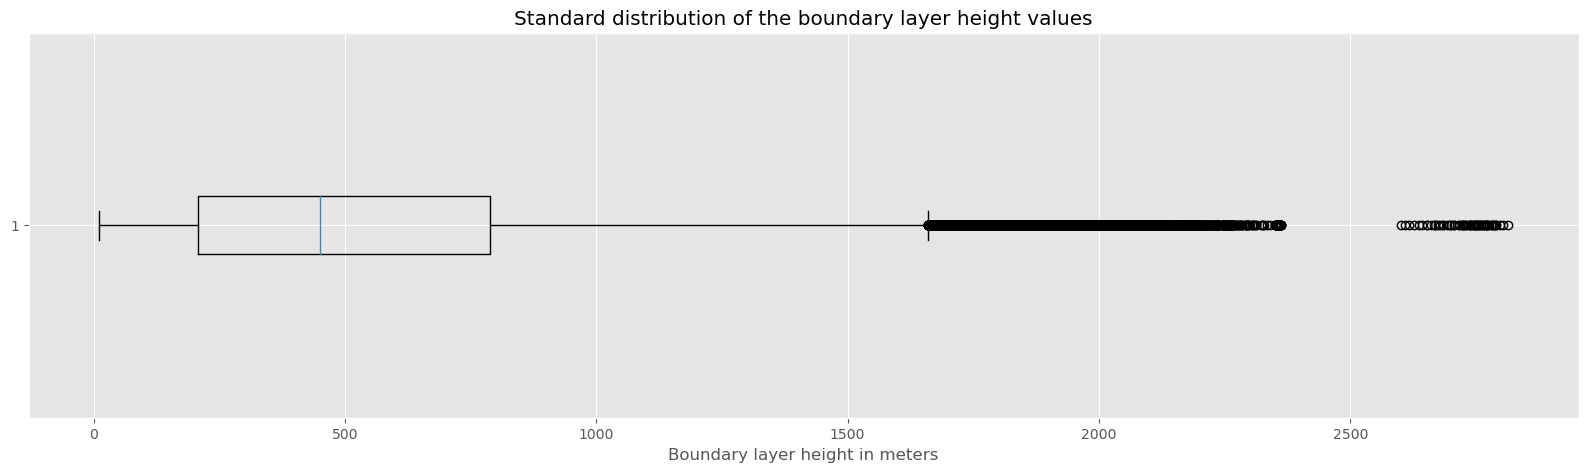

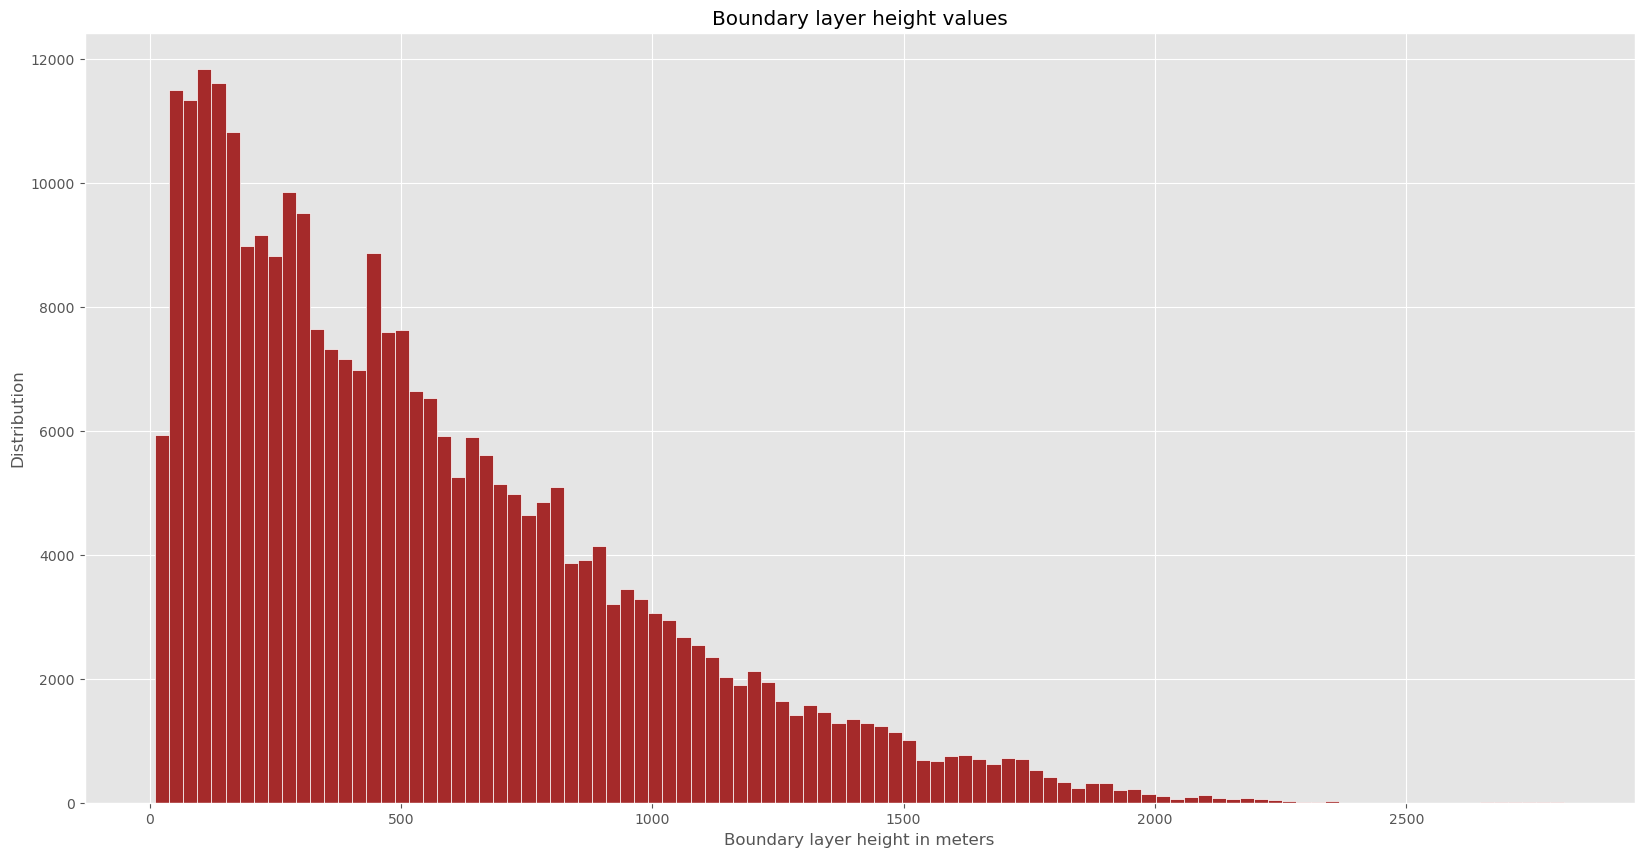

In [306]:
print("Skewness per column:")
print(df_meteo.skew(numeric_only=True))

plt.figure(figsize=(20,5))
plt.boxplot(df_meteo['blh'], vert=False)
plt.title("Standard distribution of the boundary layer height values")
plt.xlabel("Boundary layer height in meters")
plt.show()

plt.figure(figsize=(20,10))
plt.hist(df_meteo['blh'], edgecolor='white', color='brown', bins=100)
plt.title("Boundary layer height values")
plt.xlabel("Boundary layer height in meters")
plt.ylabel("Distribution")
plt.show()

The graphs represent the distribution of the boundary layer height data. The skewness of these graphs are positive. Most of the boundary layer heights are close to zero. You also don't see a lot of outliers on the bottom graph, since the tail of data is not long. This means that the distribution is devided relatively evenly.

<h4><font color=mediumvioletred>Visualize windspeed compared to solar surface radiation downwards</font></h4>

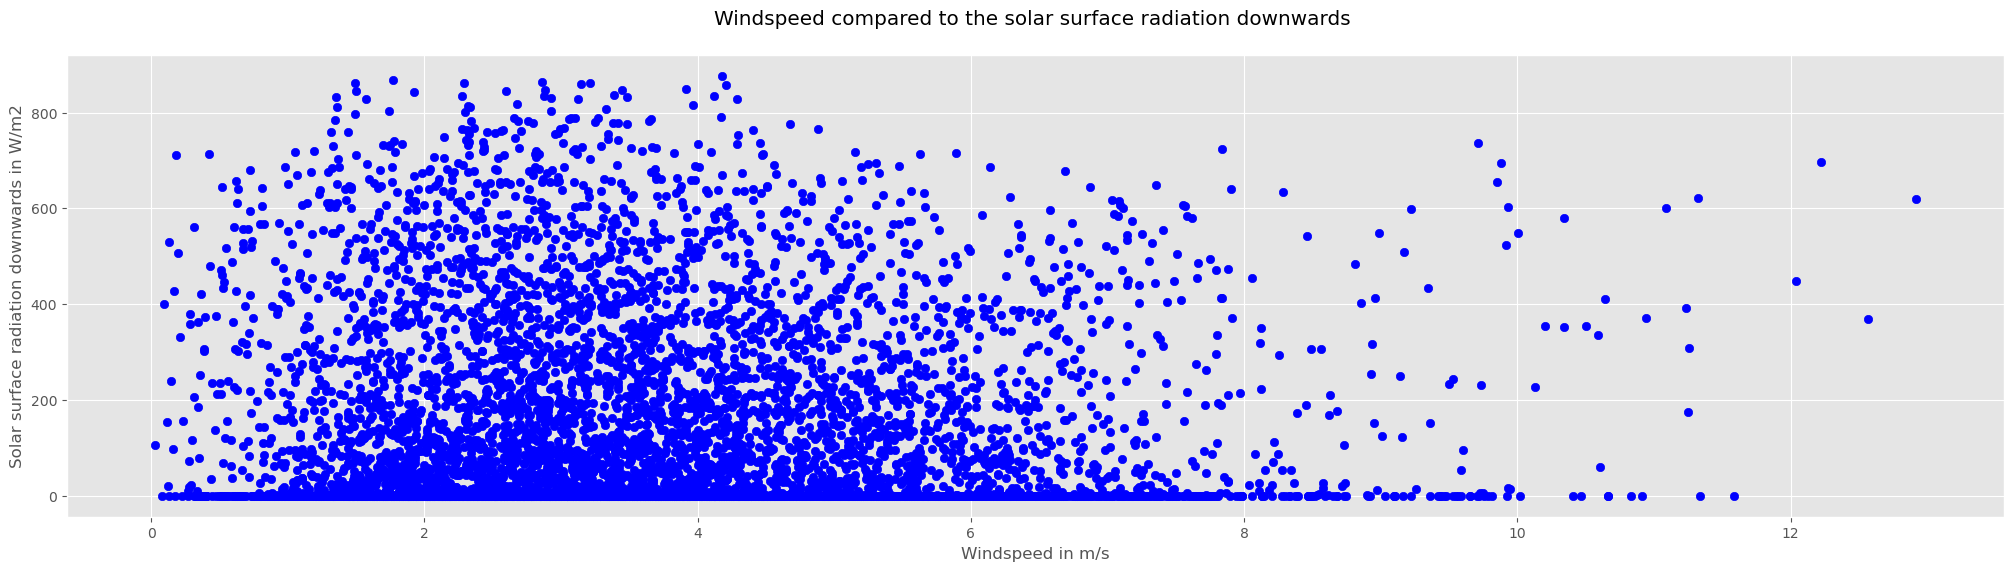

In [307]:
fig, ax = plt.subplots(figsize=(25, 6))
scatter = ax.scatter((postalcode_df_meteo["ws"]),
                list(postalcode_df_meteo["ssrd"]),
                color="blue")

ax.set(title="Windspeed compared to the solar surface radiation downwards \n",
      xlabel="Windspeed in m/s",
      ylabel="Solar surface radiation downwards in W/m2");

In the graph above you can see that the solar surface rediation downwards (ssrd) almost doesn't appear when the windspeed is above 8m/s. So there is a visable correlation between the windspeed and ssrd. It also shows the 0.000000 values of the ssrd.

<h4><font color=mediumvioletred>Visualize windspeed in September from postal code 5611</font></h4>

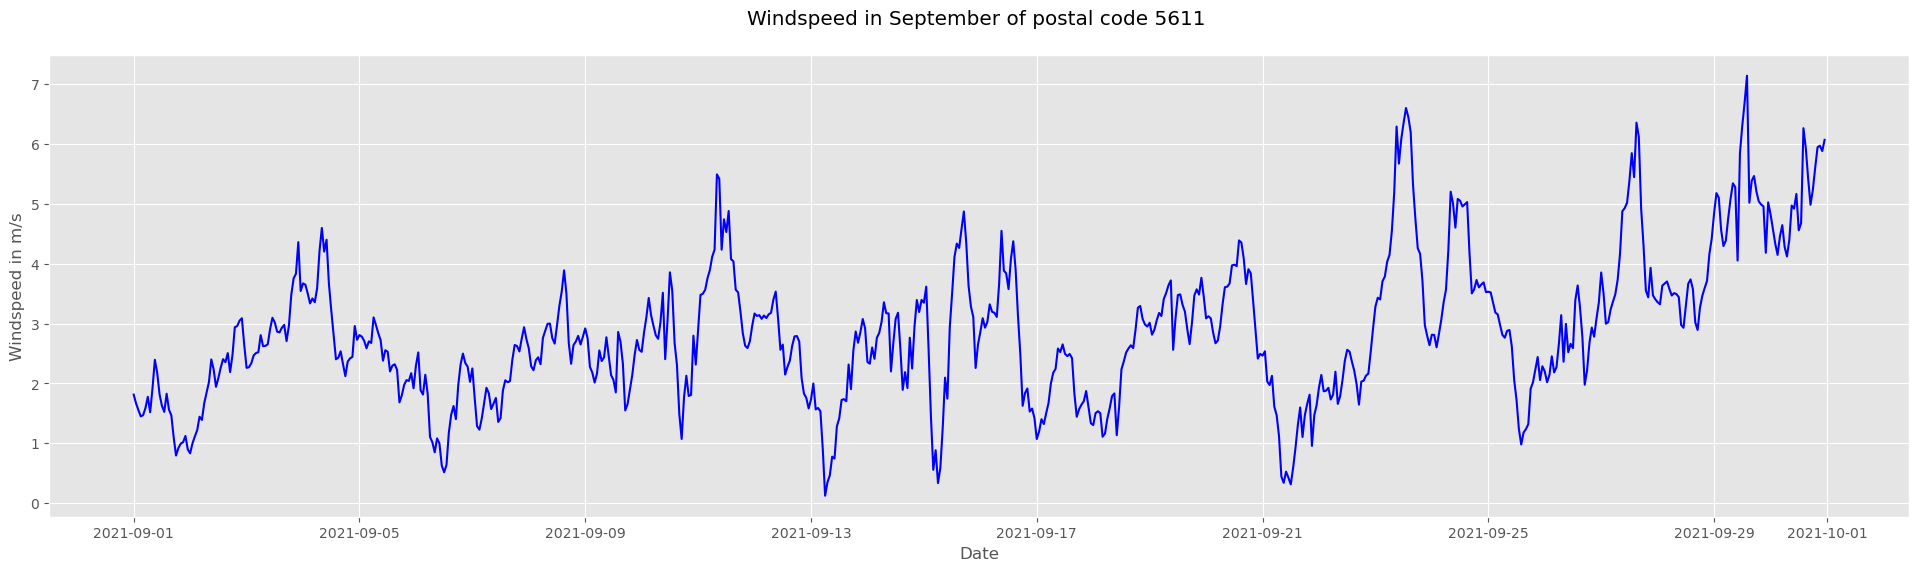

In [308]:
one_month_postalcode_df_meteo = postalcode_df_meteo[postalcode_df_meteo['date']. dt. strftime('%Y-%m')=='2021-09']

fig, ax = plt.subplots(figsize=(24, 6))
plot = ax.plot(list(one_month_postalcode_df_meteo["date"]),
                list(one_month_postalcode_df_meteo["ws"]),
                color="blue")

ax.set(title="Windspeed in September of postal code 5611 \n",
      xlabel="Date",
      ylabel="Windspeed in m/s");

No real conclusion can be drawn from just looking at the windspeed data. 

<h4><font color=mediumvioletred>Merge meteo and air pollution dataset and show sample</font></h4>

In [309]:
df_meteo_air_pollution = pd.merge(df_meteo, df_air_pollution[['PC4','date', 'pm10', 'pm2.5', 'no2',	'no', 'so2']], on=['PC4', 'date'])
df_meteo_air_pollution.sample(10)

,date,PC4,wd,ws,blh,tcc,ssrd,pm10,pm2.5,no2,no,so2
34421,2021-12-10 04:00:00,5628,302.243134,5.660480,906.039001,0.997768,0.0,14.911380,21.679440,9.409278,0.078771,0.877633
67467,2021-12-29 02:00:00,5654,177.946976,6.069271,793.285645,1.000000,0.0,16.675570,22.839200,24.628846,17.008046,2.400660
56162,2021-10-07 02:00:00,5646,171.812897,1.822121,92.028557,0.496172,0.0,20.374735,14.039240,19.726551,12.906201,3.842325
15771,2021-12-09 02:00:00,5617,250.917404,4.193567,275.866241,0.011516,0.0,20.876220,33.110630,13.996732,0.145891,2.146311
73177,2021-11-06 01:00:00,5657,223.648941,4.327627,304.413208,0.176516,0.0,9.711291,6.988477,33.881004,22.166827,6.755703
43447,2021-11-28 07:00:00,5633,83.111244,0.974621,271.308746,0.987059,0.0,20.082716,16.847923,31.415282,20.553616,2.036079
44738,2021-10-16 02:00:00,5641,205.843781,0.852781,31.457300,0.799107,0.0,18.767172,15.703601,42.579260,27.857707,0.130494
24909,2021-12-01 20:00:00,5624,158.655975,4.047348,664.372925,0.305507,0.0,15.757987,16.707483,16.894734,0.084241,1.207476
16650,2021-10-09 18:00:00,5621,23.029373,2.337617,117.519501,0.048612,0.0,29.158976,16.187284,41.406196,27.090224,10.089701
67993,2021-10-15 01:00:00,5655,224.814728,5.176976,538.716736,0.975356,0.0,5.012776,3.611257,13.610493,8.904738,3.296325


<h4><font color=mediumvioletred>Show corrolation between merged meteo and air pollution data</font></h4>

In [310]:
df_meteo_air_pollution.corr(method='spearman')

,PC4,wd,ws,blh,tcc,ssrd,pm10,pm2.5,no2,no,so2
PC4,1.000000,-0.000203,-0.001175,-0.000395,-0.000085,0.000106,-0.026865,-0.028674,-0.034462,-0.027125,0.004346
wd,-0.000203,1.000000,0.190082,0.048322,0.050032,0.032333,-0.148475,-0.106274,-0.161741,-0.109364,-0.008121
ws,-0.001175,0.190082,1.000000,0.807271,0.176822,0.073962,-0.607904,-0.472557,-0.591700,-0.499212,-0.212465
blh,-0.000395,0.048322,0.807271,1.000000,0.200182,0.341155,-0.615602,-0.542800,-0.655762,-0.502562,-0.337730
tcc,-0.000085,0.050032,0.176822,0.200182,1.000000,0.001251,-0.031441,0.110042,-0.105527,-0.186421,-0.208994
ssrd,0.000106,0.032333,0.073962,0.341155,0.001251,1.000000,-0.059004,-0.158170,-0.206825,-0.049303,-0.076840
pm10,-0.026865,-0.148475,-0.607904,-0.615602,-0.031441,-0.059004,1.000000,0.886844,0.560476,0.283385,0.336788
pm2.5,-0.028674,-0.106274,-0.472557,-0.542800,0.110042,-0.158170,0.886844,1.000000,0.431592,0.014917,0.189855
no2,-0.034462,-0.161741,-0.591700,-0.655762,-0.105527,-0.206825,0.560476,0.431592,1.000000,0.735620,0.394545
no,-0.027125,-0.109364,-0.499212,-0.502562,-0.186421,-0.049303,0.283385,0.014917,0.735620,1.000000,0.371746


With the spearman method, it can be noted that the particulate matter smaller than 2.5 micrometer (pm2.5) has the most corrolation with the boundary layer height (blh), the windspeed (ws), and nitrogen dioxide in ug/m3 (no2).

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and windspeed</font></h4>

-0.4220468437258586


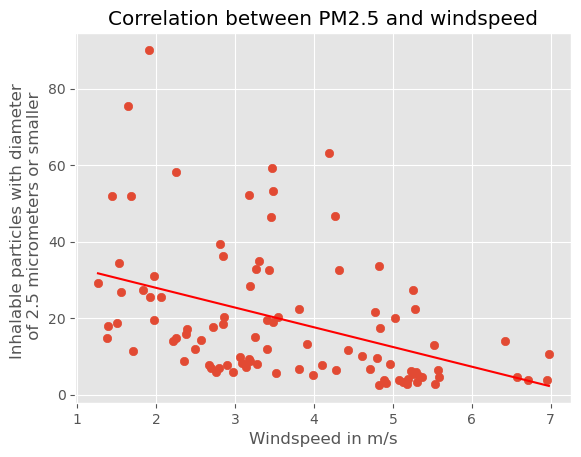

In [311]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["ws"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["ws"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["ws"]), np.poly1d(np.polyfit(group_by_day["ws"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["ws"])), color='red')
plt.title('Correlation between PM2.5 and windspeed')
plt.xlabel('Windspeed in m/s')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the windspeed keep increasing. So there is a low negative correlation between the two. Which means with higher wind speeds there are less particals of 2.5 micrometers or smaller in the air.

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and boundary layer height</font></h4>

-0.5270951619288825


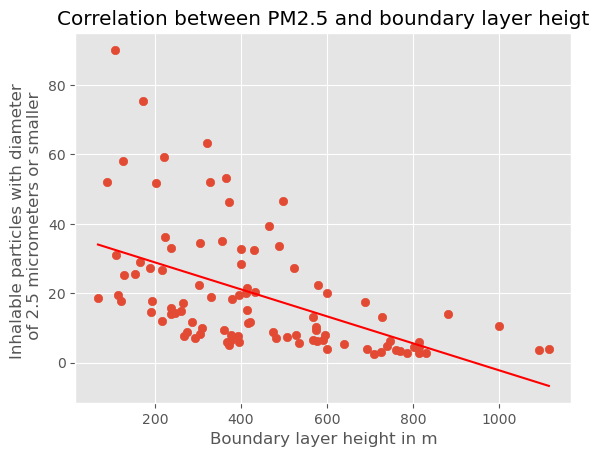

In [312]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["blh"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["blh"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["blh"]), np.poly1d(np.polyfit(group_by_day["blh"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["blh"])), color='red')
plt.title('Correlation between PM2.5 and boundary layer heigt')
plt.xlabel('Boundary layer height in m')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the boundary layer height keeps increasing. So there is a low negative correlation between the two. Which means that how higher the boundary layer, the less there are particles of 2.5 micrometer or smaller in the air.

<h4><font color=mediumvioletred>Show corrolation between particulate matter smaller than 2.5 um and solar surface radiation downwards</font></h4>

-0.44465439902953424


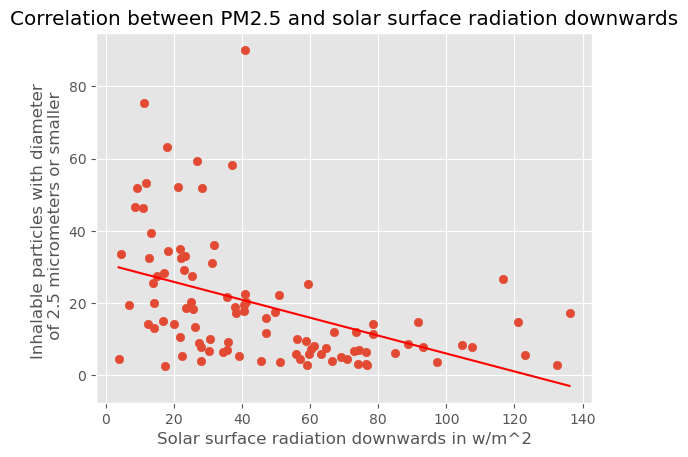

In [313]:
group_by_day = df_meteo_air_pollution.groupby(pd.Grouper(freq='D', key='date')).mean()
ws_pm25_corr = group_by_day["ssrd"].corr(group_by_day["pm2.5"])
print(ws_pm25_corr)
plt.scatter(group_by_day["ssrd"], group_by_day["pm2.5"])
plt.plot(np.unique(group_by_day["ssrd"]), np.poly1d(np.polyfit(group_by_day["ssrd"], group_by_day["pm2.5"], 1))
         (np.unique(group_by_day["ssrd"])), color='red')
plt.title('Correlation between PM2.5 and solar surface radiation downwards')
plt.xlabel('Solar surface radiation downwards in w/m^2')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller');
# Particulate matter <2.5um in ug/m3

The inhalable particles with diameter of 2.5 micrometers or smaller keep decreasing when the solar surface radiation keep increasing. So there is a low negative correlation between the two. Which means that the higher the solar surface radiation is the less there are particles smaller than 2.5 micrometer in the air.

<h4><font color=mediumvioletred> Visualize the boundary layer height for the first week of November of postal code 5611</font></h4>

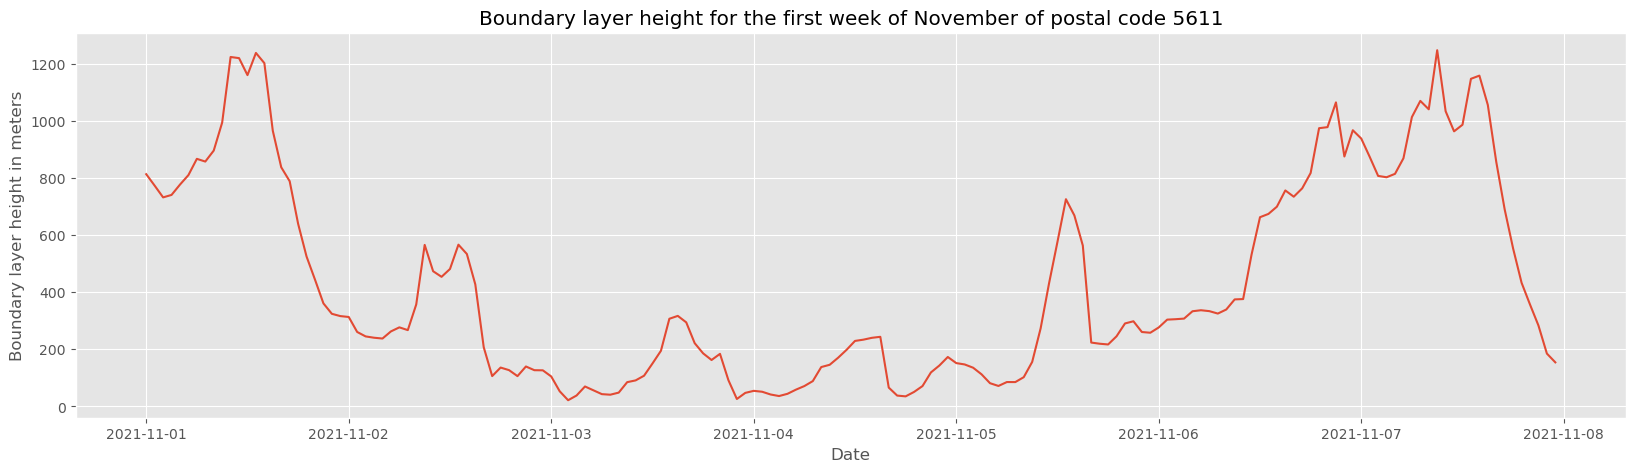

In [314]:
# Combined meto and air polution data for postalcode 5611
postalcode_df_meteo_air_polution = df_meteo_air_pollution[df_meteo_air_pollution['PC4'] == 5611]

# Combined data for the first week of november 2021 from postal code 5611 (24 * 7 = 168 entries)
one_week_postalcode_df_meteo_air_polution = postalcode_df_meteo_air_polution[postalcode_df_meteo_air_polution['date']. dt. strftime('%Y-%m')=='2021-11'].head(168)
    
plt.figure(figsize = (20 ,5))

plt.plot(one_week_postalcode_df_meteo_air_polution['date'], one_week_postalcode_df_meteo_air_polution['blh'])
 
# Adding Title to the Plot
plt.title('Boundary layer height for the first week of November of postal code 5611')

# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Boundary layer height in meters')
  
plt.show()

In the graph above you can see that almost every day at around noon the boundary layer height increases and decreases later at night. That is because the surface temperature at noon elevated lead to increased sensitive heat flux, and as a result, the boundary layer height will develop higher during daytime. 

<h4><font color=mediumvioletred> Visualize particulate matter smaller than 2.5 micrometers for the first week of November of postal code 5611</font></h4>

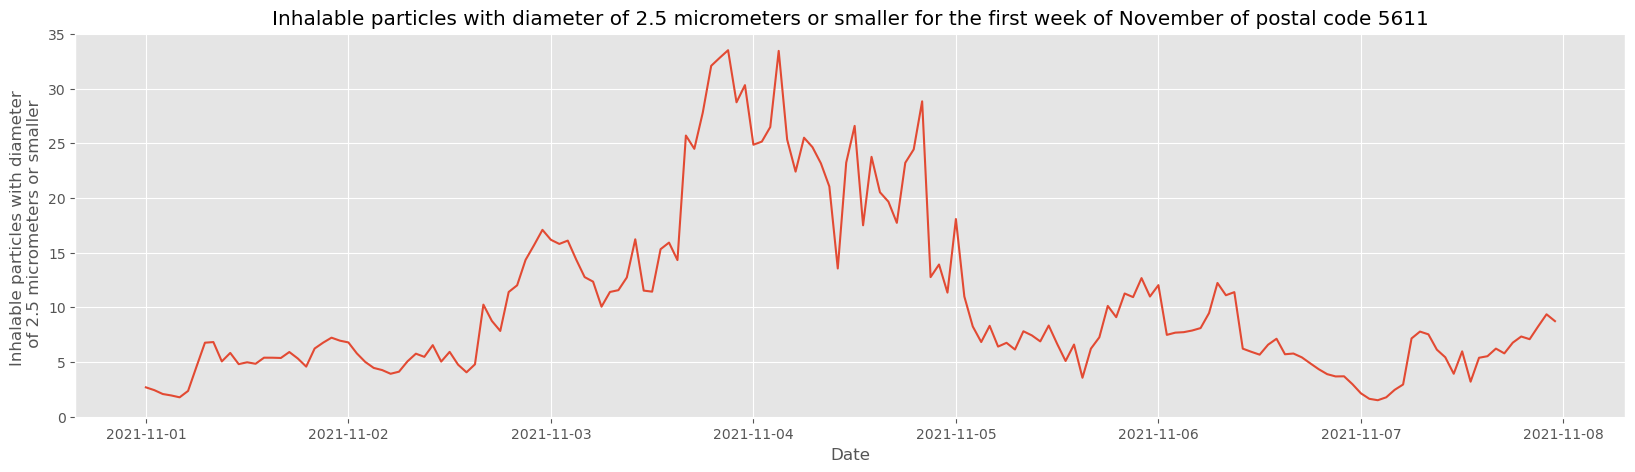

In [315]:
plt.figure(figsize = (20 ,5))

plt.plot(one_week_postalcode_df_meteo_air_polution['date'], one_week_postalcode_df_meteo_air_polution['pm2.5'])
 
# Adding Title to the Plot
plt.title('Inhalable particles with diameter of 2.5 micrometers or smaller for the first week of November of postal code 5611')

# Setting the X and Y labels
plt.xlabel('Date')
plt.ylabel('Inhalable particles with diameter \n of 2.5 micrometers or smaller')
  
plt.show()

In the graph above the particulate matter of 2.5 micrometer or smaller is visualized for the first week of November. You can see that almost every night the particals are lower then during the day. It is hard to see peaks in PM2.5 during the day but you can see a clearly difference between the particals at night and day. 

<h4><font color=mediumvioletred>Conclusion</font></h4>

After exploring and visualising the combined meteo- and pollution data, we came to the conclusion that the boundary layer height, the windspeed, the nitrogen dioxide in ug/m3, and the solar surface radiation downwards had the most corrolation on the PM2.5 values. Since this is the most important measurement of the pollution data, we devided that moving forward we are going to use this data in the air pollution prediction tool.

<h2><font color=slateblue> 5. Data Preparation </font></h2>

<h2><font color=slateblue> 6. Modelling </font></h2>